In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
import random


import glob
import os

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

def set_seed(seed_value):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch
    random.seed(seed_value)  # Python's built-in random module
    
    # minimise non-deterministic GPU behaviour
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage
set_seed(42) 

In [2]:
import numpy as np
import glob
import os
import torch

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split


class Debris_State_Series_Dataset(Dataset):
    def __init__(self, root_dir, array_size, apply_scaling=False, sequence_length=3):
        self.array_size = array_size
        self.data_files = []
        self.model_ids = []  # List to store the model IDs
        self.terrain_files = {}
        self.apply_scaling = apply_scaling
        self.sequence_length = sequence_length

        def get_state_number(file_path):
            return int(file_path.split('_')[-1].split('.')[0])

        model_dirs = glob.glob(os.path.join(root_dir, '*'))
        
        for model_dir in model_dirs:
            if os.path.isdir(model_dir):
                # Extract the model ID from the model_dir path
                model_id = os.path.basename(model_dir)

                file_patterns = {
                    'velocity': os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'velocity', '*_velocity_*.npy'),
                    'thickness': os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'thickness', '*_thickness_*.npy')
                }
                file_collections = {key: sorted(glob.glob(pattern), key=get_state_number) for key, pattern in file_patterns.items()}

                terrain_pattern = os.path.join(model_dir, f'04_FinalProcessedData_{str(self.array_size)}', 'elevation', '*_elevation.npy')
                terrain_file = glob.glob(terrain_pattern)

                if terrain_file:
                    self.terrain_files[model_dir] = terrain_file[0]

                num_states = len(file_collections['velocity'])
                for i in range(num_states):
                    start_index = max(0, i - self.sequence_length + 1)
                    end_index = i + 1
                    sequence_velocity = file_collections['velocity'][start_index:end_index]
                    sequence_thickness = file_collections['thickness'][start_index:end_index]

                    # Pad the sequences with None if they are shorter than the desired length
                    sequence_velocity = [None] * (self.sequence_length - len(sequence_velocity)) + sequence_velocity
                    sequence_thickness = [None] * (self.sequence_length - len(sequence_thickness)) + sequence_thickness

                    if i + 1 < num_states:
                        next_velocity = file_collections['velocity'][i+1]
                        next_thickness = file_collections['thickness'][i+1]
                        self.data_files.append((sequence_velocity, sequence_thickness, next_velocity, next_thickness))
                        self.model_ids.append(model_id)

    def compute_scaling_factors(self):

        # Ensure that scaling is intended before computing factors
        if not self.apply_scaling:
            raise RuntimeError("Scaling factors called to be computed when scaling is not applied.")

        # Initialize min and max values with infinities
        self.min_elevation = np.inf
        self.max_elevation = -np.inf
        self.min_velocity = np.inf
        self.max_velocity = -np.inf
        self.min_thickness = np.inf
        self.max_thickness = -np.inf

        # Compute min and max values over the training set
        for model_dir, terrain_path in self.terrain_files.items():
            terrain = np.load(terrain_path)
            self.min_elevation = min(self.min_elevation, terrain.min())
            self.max_elevation = max(self.max_elevation, terrain.max())

            # Assuming that velocity and thickness files are matched in the data_files
            for velocity_path, _, thickness_path, _ in self.data_files:
                if model_dir in velocity_path:  # Checking if the file belongs to the current model directory
                    velocity = np.load(velocity_path)
                    thickness = np.load(thickness_path)
                    self.min_velocity = min(self.min_velocity, velocity.min())
                    self.max_velocity = max(self.max_velocity, velocity.max())
                    self.min_thickness = min(self.min_thickness, thickness.min())
                    self.max_thickness = max(self.max_thickness, thickness.max())

    def scale_data(self, terrain, velocity, thickness):
        # Apply Min-Max scaling to each feature
        terrain_scaled = (terrain - self.min_elevation) / (self.max_elevation - self.min_elevation) * 10
        velocity_scaled = (velocity - self.min_velocity) / (self.max_velocity - self.min_velocity) * 10 
        thickness_scaled = (thickness - self.min_thickness) / (self.max_thickness - self.min_thickness) * 10
        return terrain_scaled, velocity_scaled, thickness_scaled

    def __len__(self):
        return len(self.data_files)
    
    def __getitem__(self, idx):
        velocity_sequence, thickness_sequence, next_velocity_path, next_thickness_path = self.data_files[idx]

        # Get the model directory from the next velocity path
        model_dir = os.path.dirname(os.path.dirname(os.path.dirname(next_velocity_path)))

        # Load the corresponding terrain file
        terrain_path = self.terrain_files[model_dir]
        terrain = np.load(terrain_path)

        # Initialize empty lists to store the sequence data
        input_sequence_data = []

        # Load and process each state in the sequence
        for i in range(self.sequence_length):
            if i < len(velocity_sequence) and velocity_sequence[i] is not None and thickness_sequence[i] is not None:
                velocity = np.load(velocity_sequence[i])
                thickness = np.load(thickness_sequence[i])

                if self.apply_scaling:
                    _, velocity_scaled, thickness_scaled = self.scale_data(terrain, velocity, thickness)
                    input_sequence_data.append(np.stack((terrain, thickness_scaled, velocity_scaled), axis=0))
                else:
                    input_sequence_data.append(np.stack((terrain, thickness, velocity), axis=0))
            else:
                # If the file path is None or the sequence is shorter than the desired length, pad with zeros
                input_sequence_data.append(np.zeros((3, terrain.shape[0], terrain.shape[1])))

        # Stack the sequence data
        input_sequence_data = np.stack(input_sequence_data, axis=0)

        if next_velocity_path is not None and next_thickness_path is not None:
            # Load next states for velocity and thickness
            next_velocity = np.load(next_velocity_path)
            next_thickness = np.load(next_thickness_path)

            if self.apply_scaling:
                _, next_velocity_scaled, next_thickness_scaled = self.scale_data(terrain, next_velocity, next_thickness)
                cnn_output = np.stack((next_thickness_scaled, next_velocity_scaled), axis=0)
            else:
                cnn_output = np.stack((next_thickness, next_velocity), axis=0)
        else:
            # If the next velocity or thickness path is None, return arrays of zeros
            cnn_output = np.zeros((2, terrain.shape[0], terrain.shape[1]))

        return torch.from_numpy(input_sequence_data).float(), torch.from_numpy(cnn_output).float()


    def create_dataloaders(self, split_proportions, batch_size, random_state=42):
        # Unpack the proportions for clarity
        train_proportion, val_proportion, test_proportion = split_proportions
        
        # Assert that the proportions sum to 1
        assert np.isclose(sum(split_proportions), 1.0), "Proportions must sum up to 1."
        
        # Create a list of unique model IDs
        unique_model_ids = np.unique(self.model_ids)
        
        # Split model IDs into train, val, and test sets
        train_model_ids, temp_model_ids = train_test_split(
            unique_model_ids, test_size=(val_proportion + test_proportion), random_state=random_state
        )
        val_model_ids, test_model_ids = train_test_split(
            temp_model_ids, test_size=test_proportion / (val_proportion + test_proportion), random_state=random_state
        )
        
        # Now, filter the dataset's data points based on the model IDs
        train_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in train_model_ids]
        val_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in val_model_ids]
        test_indices = [i for i, model_id in enumerate(self.model_ids) if model_id in test_model_ids]
        
        # Create subsets
        train_dataset = Subset(self, train_indices)
        val_dataset = Subset(self, val_indices)
        test_dataset = Subset(self, test_indices)
        
        # DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Return the DataLoaders
        return train_loader, val_loader, test_loader
    
    def get_sequence_filenames(self):
        """Retrieves filenames from the data_files attribute and includes corresponding terrain file."""
        sequence_info = []
        for velocity_sequence, thickness_sequence, next_velocity, next_thickness in self.data_files:
            # Extract filenames from paths, handling None values
            velocity_filenames = [os.path.basename(v) if v else None for v in velocity_sequence]
            thickness_filenames = [os.path.basename(t) if t else None for t in thickness_sequence]
            next_velocity_filename = os.path.basename(next_velocity)
            next_thickness_filename = os.path.basename(next_thickness)
            
            # Get the model directory from the next velocity path
            # Assuming the directory structure remains consistent for all files
            model_dir = os.path.dirname(os.path.dirname(os.path.dirname(next_velocity)))
            
            # Retrieve the terrain filename
            terrain_filename = os.path.basename(self.terrain_files[model_dir]) if model_dir in self.terrain_files else None

            # Store the filenames of the full sequence including the terrain
            sequence_info.append({
                'velocity_sequence': velocity_filenames,
                'thickness_sequence': thickness_filenames,
                'next_velocity': next_velocity_filename,
                'next_thickness': next_thickness_filename,
                'terrain': terrain_filename
            })
        return sequence_info

In [3]:
# WORKING - SIMPLE

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.bias = bias
        self.padding = self.padding = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)

        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=4 * hidden_dim,  # for input, forget, cell, and output gates
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along the channel dimension
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))
    
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim):
        super(ConvLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        layers = []
        for i in range(self.num_layers):
            in_channels = self.input_dim if i == 0 else self.hidden_dim
            layers.append(ConvLSTMCell(in_channels, self.hidden_dim, self.kernel_size, bias=True))
        self.layers = nn.ModuleList(layers)
        self.final_conv = nn.Conv2d(self.hidden_dim, self.output_dim, kernel_size=1)

    def forward(self, x, hidden=None):
        # x of shape (batch, seq_len, channels, height, width)
        batch_size, seq_len, _, height, width = x.size()

        if hidden is None:
            hidden = [layer.init_hidden(batch_size, (height, width)) for layer in self.layers]

        current_input = x.transpose(0, 1)  # Swap batch and seq_len dimensions
        for layer_idx, layer in enumerate(self.layers):
            output_inner = []
            for t in range(seq_len):
                hidden[layer_idx] = layer(current_input[t], hidden[layer_idx])
                output_inner.append(hidden[layer_idx][0])
            current_input = torch.stack(output_inner, 0)

        # Take the last output of the sequence
        last_seq_output = current_input[-1]

        # Apply the final convolution to get the output
        output = self.final_conv(last_seq_output)

        return output, hidden

    def init_hidden(self, batch_size, image_size):
        return [layer.init_hidden(batch_size, image_size) for layer in self.layers]
    

    

In [4]:
## Working also

class ConvLSTMCell_Complex(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True, dropout_rate=0.0):
        super(ConvLSTMCell_Complex, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.bias = bias
        self.dropout_rate = dropout_rate
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)

        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=4 * hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)
        self.dropout = nn.Dropout2d(self.dropout_rate)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        c_next = self.dropout(c_next)  # Apply dropout to cell state
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
    
    def init_hidden(self, batch_size, spatial_dims):
        height, width = spatial_dims
        h = torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)
        c = torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device)
        return (h, c)

class ConvLSTM_Complex(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_dim, dropout_rate=0.0):
        super(ConvLSTM_Complex, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout_rate = dropout_rate

        layers = []
        for i in range(self.num_layers):
            in_channels = self.input_dim if i == 0 else self.hidden_dim
            layers.append(ConvLSTMCell_Complex(in_channels, self.hidden_dim, self.kernel_size, bias=True, dropout_rate=self.dropout_rate))
        self.layers = nn.ModuleList(layers)
        self.final_conv = nn.Conv2d(self.hidden_dim, self.output_dim, kernel_size=1)

    def forward(self, x, hidden=None):
        batch_size, seq_len, _, height, width = x.size()
        if hidden is None:
            hidden = [layer.init_hidden(batch_size, (height, width)) for layer in self.layers]
        current_input = x.transpose(0, 1)  # Swap batch and seq_len dimensions
        for layer_idx, layer in enumerate(self.layers):
            output_inner = []
            for t in range(seq_len):
                hidden[layer_idx] = layer(current_input[t], hidden[layer_idx])
                output_inner.append(hidden[layer_idx][0])
            current_input = torch.stack(output_inner, 0)
        last_seq_output = current_input[-1]
        output = self.final_conv(last_seq_output)
        return output, hidden

In [5]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        if x.shape != skip.shape:
            x = torch.nn.functional.pad(x, (0, skip.shape[3] - x.shape[3], 0, skip.shape[2] - x.shape[2]))
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class UNetLSTM(nn.Module):
    def __init__(self, input_channels=3, output_channels=2, hidden_size=512):
        super().__init__()
        self.enc1 = EncoderBlock(input_channels, 16)
        self.enc2 = EncoderBlock(16, 32)
        self.enc3 = EncoderBlock(32, 64)
        self.enc4 = EncoderBlock(64, 128)
        self.enc5 = EncoderBlock(128, 256)
        self.conv_block = ConvBlock(256, 512)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.lstm = nn.LSTM(512, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 512)
        self.reshape = nn.Unflatten(1, (512, 1, 1))
        self.dec5 = DecoderBlock(512, 256)
        self.dec4 = DecoderBlock(256, 128)
        self.dec3 = DecoderBlock(128, 64)
        self.dec2 = DecoderBlock(64, 32)
        self.dec1 = DecoderBlock(32, 16)
        self.final_conv = nn.Conv2d(16, output_channels, kernel_size=1)

    def forward(self, x):
        batch_size, seq_len, _, _, _ = x.size()
        outputs = []
        for t in range(seq_len):
            x_t, skip1 = self.enc1(x[:, t])
            x_t, skip2 = self.enc2(x_t)
            x_t, skip3 = self.enc3(x_t)
            x_t, skip4 = self.enc4(x_t)
            x_t, skip5 = self.enc5(x_t)
            x_t = self.conv_block(x_t)
            x_t = self.gap(x_t)
            x_t = x_t.view(batch_size, -1).unsqueeze(1)
            outputs.append(x_t)
        x = torch.cat(outputs, dim=1)

        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        x = self.reshape(x)

        x = self.dec5(x, skip5)
        x = self.dec4(x, skip4)
        x = self.dec3(x, skip3)
        x = self.dec2(x, skip2)
        x = self.dec1(x, skip1)
        x = self.final_conv(x)
        return x, None

In [6]:
import os
import numpy as np
import torch
import json
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader



class Trainer:
    def __init__(self, model, optimizer, criterion, device, model_name="", checkpoint_dir="model_checkpoints"):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model_name = model_name.strip()
        self.checkpoint_dir = checkpoint_dir.strip()
        self.training_losses = []
        self.validation_losses = []

        # Ensure the checkpoint directory exists
        self.checkpoint_dir = os.path.join(self.checkpoint_dir, self.model_name) if self.model_name else self.checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def train(self, train_loader, val_loader, epochs, checkpoint_interval=5):
        self.model.train()
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0.0
            for sequence, next_state in train_loader:
                sequence = sequence.to(self.device)
                next_state = next_state.to(self.device)
                
                self.optimizer.zero_grad()
                predictions, _ = self.model(sequence)

                # print("predictions shape: ", predictions.shape)  # Expected to match the shape of `next_state`
                # print("next state shape: ", next_state.shape)


                loss = self.criterion(predictions, next_state)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            self.training_losses.append(avg_loss)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

            # Validation step
            val_loss = self.validate(val_loader)
            self.validation_losses.append(val_loss)

            # Save the model at the specified checkpoint interval
            if (epoch + 1) % checkpoint_interval == 0:
                self.save_checkpoint(epoch + 1)
                self.save_losses(epoch + 1)

        # Save checkpoint after the final epoch
        self.save_checkpoint(epochs)

        # Save losses after the final epoch
        self.save_losses(epochs)

        # After training, plot the training and validation losses
        self.plot_losses()

    def validate(self, val_loader):
        self.model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for sequence, next_state in val_loader:
                sequence = sequence.to(self.device)
                next_state = next_state.to(self.device)
                predictions, _ = self.model(sequence)
                loss = self.criterion(predictions, next_state)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss:.4f}')
        return avg_val_loss

    def save_checkpoint(self, epoch):
        checkpoint_file = f'model_epoch_{epoch}.pth'
        checkpoint_path = os.path.join(self.checkpoint_dir, checkpoint_file)
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

    def save_losses(self, epoch):
        losses_file = f'losses_epoch_{epoch}.json'
        losses_path = os.path.join(self.checkpoint_dir, losses_file)

        losses = {
            'training_losses': self.training_losses,
            'validation_losses': self.validation_losses
        }
        
        with open(losses_path, 'w') as f:
            json.dump(losses, f, indent=4)
        
        print(f'Losses saved to {losses_path}')

    def load_losses(self):
        losses_file = 'losses.json'
        losses_path = os.path.join(self.checkpoint_dir, losses_file)

        with open(losses_path, 'r') as f:
            losses = json.load(f)
        self.training_losses = losses['training_losses']
        self.validation_losses = losses['validation_losses']
        print(f'Losses loaded from {losses_path}')

    def test(self, test_loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for current, next_velocity in test_loader:
                current = current.to(self.device)
                next_velocity = next_velocity.to(self.device)
                
                predictions, _ = self.model(current)  # Unpack the tuple if your model returns more than one output
                loss = self.criterion(predictions, next_velocity)
                total_loss += loss.item()
        avg_loss = total_loss / len(test_loader)
        print(f'Test Loss: {avg_loss:.4f}')

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.training_losses, label='Training Loss')
        plt.plot(self.validation_losses, label='Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save the plot as an image file
        plot_file = 'loss_plot.png'
        plot_path = os.path.join(self.checkpoint_dir, plot_file)
        plt.savefig(plot_path)
        print(f'Loss plot saved to {plot_path}')

        # Show the plot
        plt.show()

    def plot_results(self, test_loader, num_samples=5):
        self.model.eval()
        with torch.no_grad():
            for i, (sequence, next_state) in enumerate(test_loader):
                if i >= num_samples:
                    break

                sequence = sequence.to(self.device)
                next_state = next_state.to(self.device)

                predictions, _ = self.model(sequence)

                # Move the data back to the CPU for plotting
                next_state = next_state.cpu().numpy()
                predictions = predictions.cpu().numpy()

                # Plot the expected and predicted results side by side
                fig, axes = plt.subplots(3, 2, figsize=(12, 18))

                # Process and plot each type of data (thickness, velocity)
                for index, title in enumerate(['Thickness', 'Velocity']):
                    # Determine color limits based on the expected values
                    vmin = np.min(next_state[0, index])
                    vmax = np.max(next_state[0, index])

                    # Expected
                    im = axes[index, 0].imshow(next_state[0, index], cmap='viridis', vmin=vmin, vmax=vmax)
                    axes[index, 0].set_title(f"Expected {title}")
                    axes[index, 0].axis('off')
                    fig.colorbar(im, ax=axes[index, 0], orientation='vertical')

                    # Predicted
                    im = axes[index, 1].imshow(predictions[0, index], cmap='viridis', vmin=vmin, vmax=vmax)
                    axes[index, 1].set_title(f"Predicted {title}")
                    axes[index, 1].axis('off')
                    fig.colorbar(im, ax=axes[index, 1], orientation='vertical')

                # Compute and plot the differences for thickness and velocity
                for index, title in enumerate(['Thickness', 'Velocity']):
                    diff = np.abs(next_state[0, index] - predictions[0, index])
                    vmax = np.max(diff)  # Dynamic range based on the actual differences observed

                    im = axes[2, index].imshow(diff, cmap='hot', vmin=0, vmax=vmax)
                    axes[2, index].set_title(f"Difference in {title}")
                    axes[2, index].axis('off')
                    fig.colorbar(im, ax=axes[2, index], orientation='vertical')

                plt.tight_layout()
                plt.show()

    # def plot_results(self, test_loader, num_samples=5):
    #     self.model.eval()
    #     with torch.no_grad():
    #         for i, (sequence, next_state) in enumerate(test_loader):
    #             if i >= num_samples:
    #                 break

    #             sequence = sequence.to(self.device)
    #             next_state = next_state.to(self.device)

    #             predictions, _ = self.model(sequence)

    #             # Move the data back to the CPU for plotting
    #             next_state = next_state.cpu().numpy()
    #             predictions = predictions.cpu().numpy()

    #             # Plot the expected and predicted results side by side
    #             fig, axes = plt.subplots(3, 2, figsize=(12, 18))

    #             # Define the maximum thickness and velocity
    #             max_thickness = 10
    #             max_velocity = 30

    #             # Plot the expected thickness
    #             im = axes[0, 0].imshow(next_state[0, 0], cmap='viridis', vmin=0, vmax=max_thickness)
    #             axes[0, 0].set_title("Expected Thickness")
    #             axes[0, 0].axis('off')
    #             fig.colorbar(im, ax=axes[0, 0], orientation='vertical')

    #             # Plot the predicted thickness
    #             im = axes[0, 1].imshow(predictions[0, 0], cmap='viridis', vmin=0, vmax=max_thickness)
    #             axes[0, 1].set_title("Predicted Thickness")
    #             axes[0, 1].axis('off')
    #             fig.colorbar(im, ax=axes[0, 1], orientation='vertical')

    #             # Plot the expected velocity
    #             im = axes[1, 0].imshow(next_state[0, 1], cmap='viridis', vmin=0, vmax=max_velocity)
    #             axes[1, 0].set_title("Expected Velocity")
    #             axes[1, 0].axis('off')
    #             fig.colorbar(im, ax=axes[1, 0], orientation='vertical')

    #             # Plot the predicted velocity
    #             im = axes[1, 1].imshow(predictions[0, 1], cmap='viridis', vmin=0, vmax=max_velocity)
    #             axes[1, 1].set_title("Predicted Velocity")
    #             axes[1, 1].axis('off')
    #             fig.colorbar(im, ax=axes[1, 1], orientation='vertical')

    #             # Compute and plot the absolute difference for thickness and velocity normalized to 0-1
    #             thickness_diff = np.abs(next_state[0, 0] - predictions[0, 0]) / max_thickness
    #             velocity_diff = np.abs(next_state[0, 1] - predictions[0, 1]) / max_velocity

    #             im = axes[2, 0].imshow(thickness_diff, cmap='hot', vmin=0, vmax=1)
    #             axes[2, 0].set_title("Difference in Thickness")
    #             axes[2, 0].axis('off')
    #             fig.colorbar(im, ax=axes[2, 0], orientation='vertical')

    #             im = axes[2, 1].imshow(velocity_diff, cmap='hot', vmin=0, vmax=1)
    #             axes[2, 1].set_title("Difference in Velocity")
    #             axes[2, 1].axis('off')
    #             fig.colorbar(im, ax=axes[2, 1], orientation='vertical')

    #             plt.tight_layout()
    #             plt.show()



In [7]:
import random
from torch.optim import Adam



root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 64
split_proportions = (0.7, 0.15, 0.15)
epochs = 50
seq_length = 10  # Specify the sequence length for the ConvLSTMUNet

# Data set up

# Initialize dataset with scaling
dataset = Debris_State_Series_Dataset(root_dir=root_dir, array_size=256, apply_scaling=False, sequence_length=seq_length)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

# Compute scaling factors based on the train dataset, but only if scaling is applied
if dataset.apply_scaling:
    train_dataset = train_loader.dataset.dataset 
    dataset.compute_scaling_factors()

# Dataset stats (optional)
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")



Total dataset size: 55718
Train size: 39370, Validation size: 8016, Test size: 8332


In [8]:
# sequence_filenames = dataset.get_sequence_filenames()

# # Print the filenames for debugging
# for index, sequence in enumerate(sequence_filenames):
#     print(f"Sequence {index + 1}:")
#     print("Velocity Sequence Files:", sequence['velocity_sequence'])
#     print("Thickness Sequence Files:", sequence['thickness_sequence'])
#     print("Next Velocity File:", sequence['next_velocity'])
#     print("Next Thickness File:", sequence['next_thickness'])
#     print("Terrain File:", sequence['terrain'])
#     print()

In [9]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Define the ConvLSTMUNet model
in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)
hidden_dim = 64  # Hidden dimension of the ConvLSTM
kernel_size = (3, 3)  # Kernel size of the ConvLSTM
# model = ConvLSTM(input_dim=in_channels, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=1, output_dim=out_channels)
# model = UNetLSTM(in_channels, out_channels)
# model = ConvLSTM_Complex(input_dim=in_channels, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=1, output_dim=out_channels)
# model = UNetWithConvLSTM(in_channels, out_channels)
model = UNetLSTM(input_channels=in_channels)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    model = torch.nn.DataParallel(model)

model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# # Initialize the trainer
model_name = "UnetLSTM"
trainer = Trainer(model=model, optimizer=optimizer, criterion=criterion, device=device, model_name=model_name, checkpoint_dir=checkpoint_dir)


Training on device: cuda.
Using 2 GPUs!


Training UnetLSTM...
Epoch [1/50], Loss: 0.0749
Validation Loss: 0.0619
Epoch [2/50], Loss: 0.0544
Validation Loss: 0.0584
Epoch [3/50], Loss: 0.0514
Validation Loss: 0.0554
Epoch [4/50], Loss: 0.0496
Validation Loss: 0.0539
Epoch [5/50], Loss: 0.0471
Validation Loss: 0.0505
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/UnetLSTM/model_epoch_5.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/UnetLSTM/losses_epoch_5.json
Epoch [6/50], Loss: 0.0446
Validation Loss: 0.0494
Epoch [7/50], Loss: 0.0435
Validation Loss: 0.0475
Epoch [8/50], Loss: 0.0420
Validation Loss: 0.0486
Epoch [9/50], Loss: 0.0412
Validation Loss: 0.0473
Epoch [10/50], Loss: 0.0405
Validation Loss: 0.0491
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/UnetLSTM/model_epoch_10.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/UnetLSTM/losses_epoch_10.json
Epoch [11/50], Loss: 0.0398
Validation Loss: 0.0470
Epoch [12/50], Loss: 0.0395


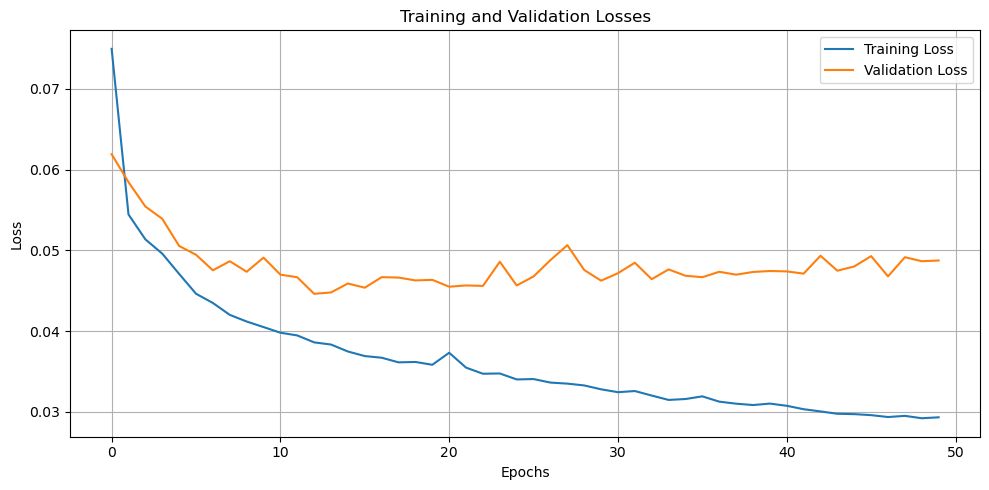

Finished training UnetLSTM.


In [10]:
# Train the model
print(f"Training {model_name}...")
trainer.train(train_loader, val_loader, epochs=epochs, checkpoint_interval=5)

print(f"Finished training {model_name}.")

In [11]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
trainer.test(test_loader)

Evaluating the model on the test set...
Test Loss: 0.0592


Plotting the expected vs predicted results...


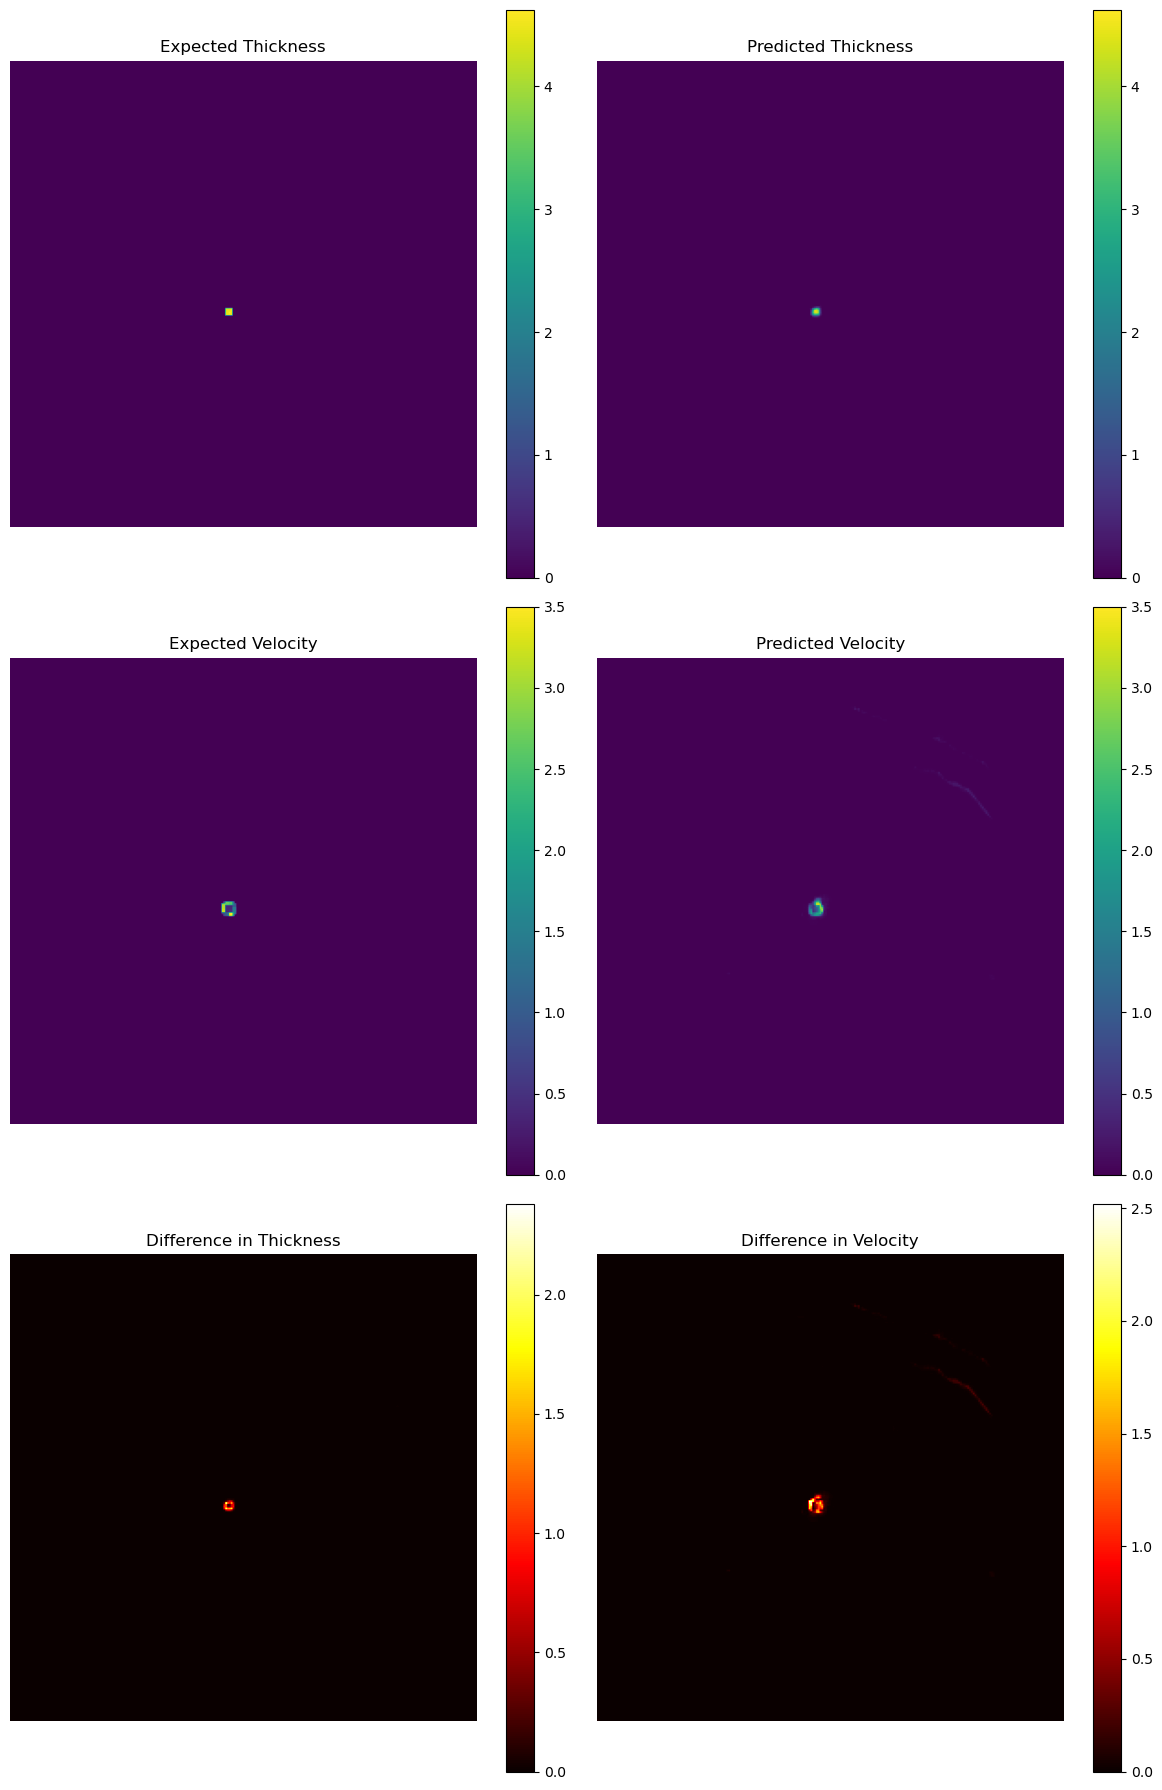

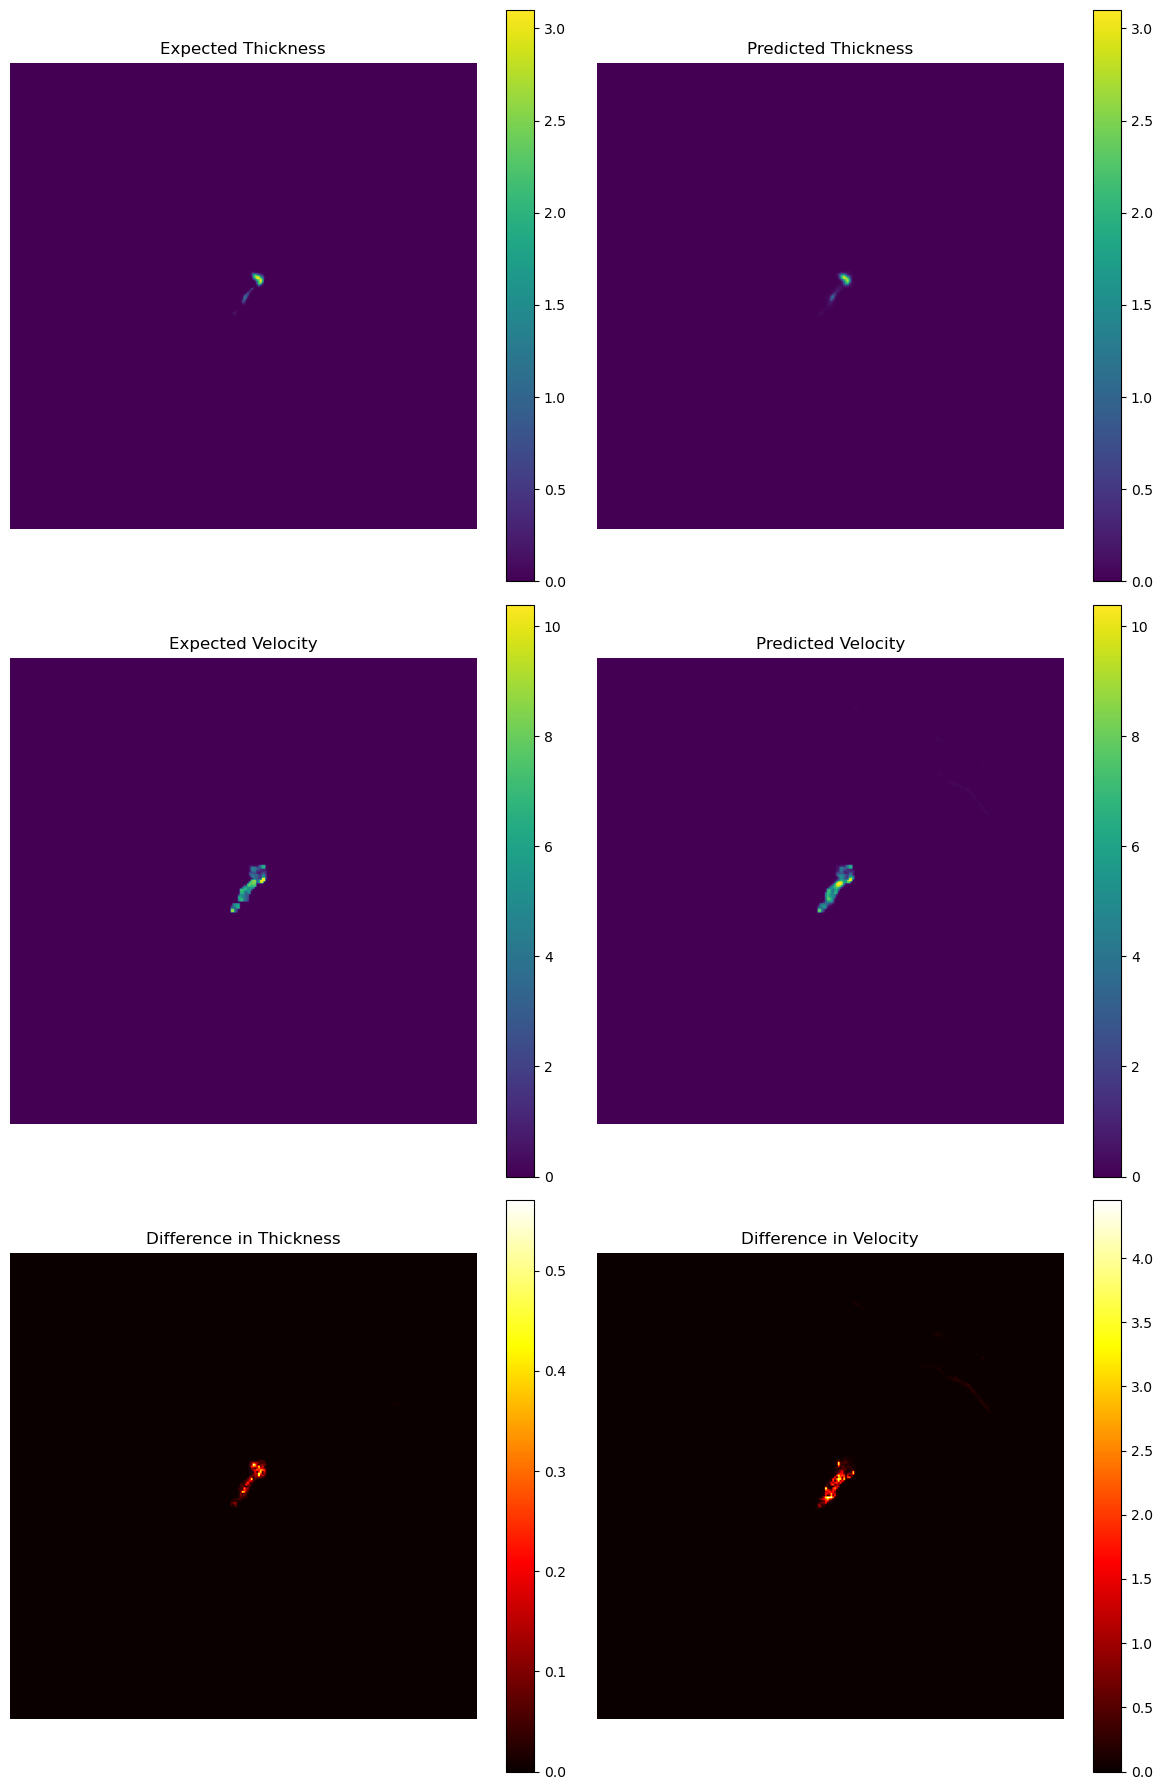

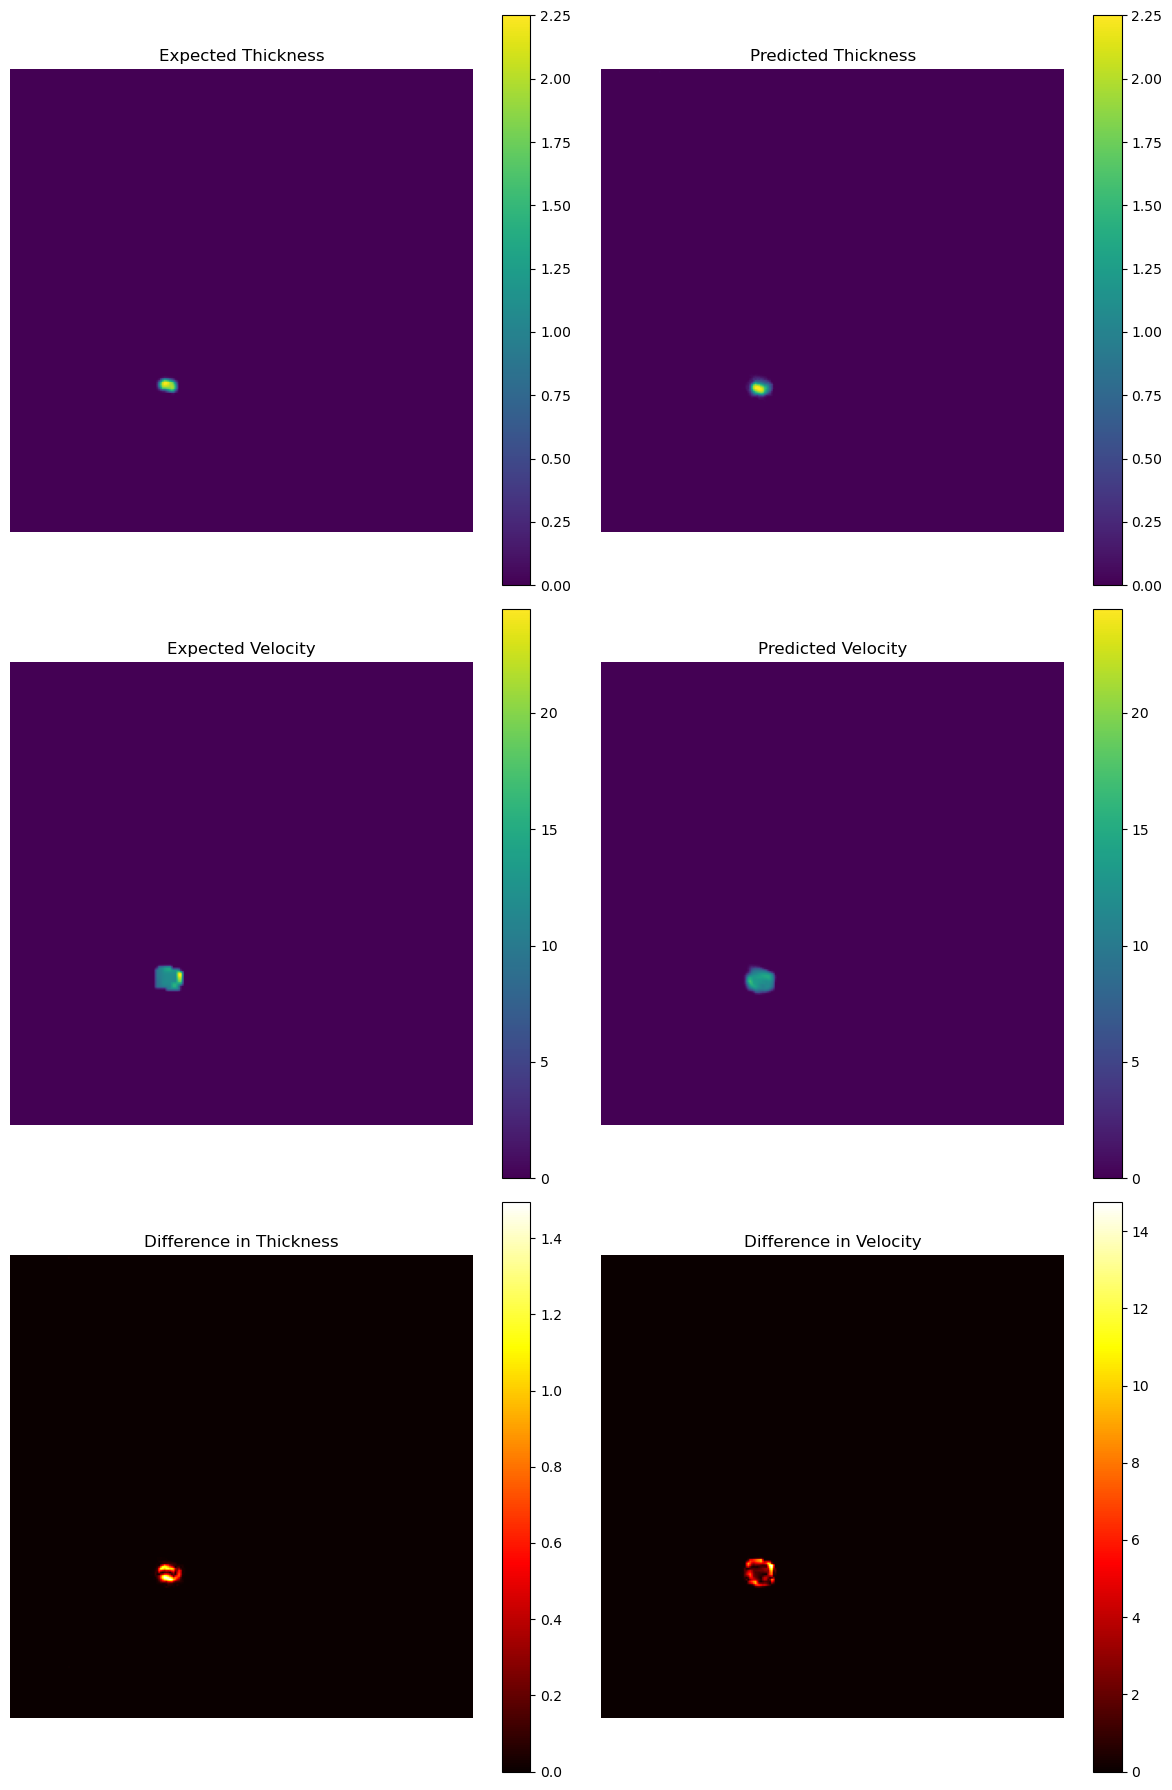

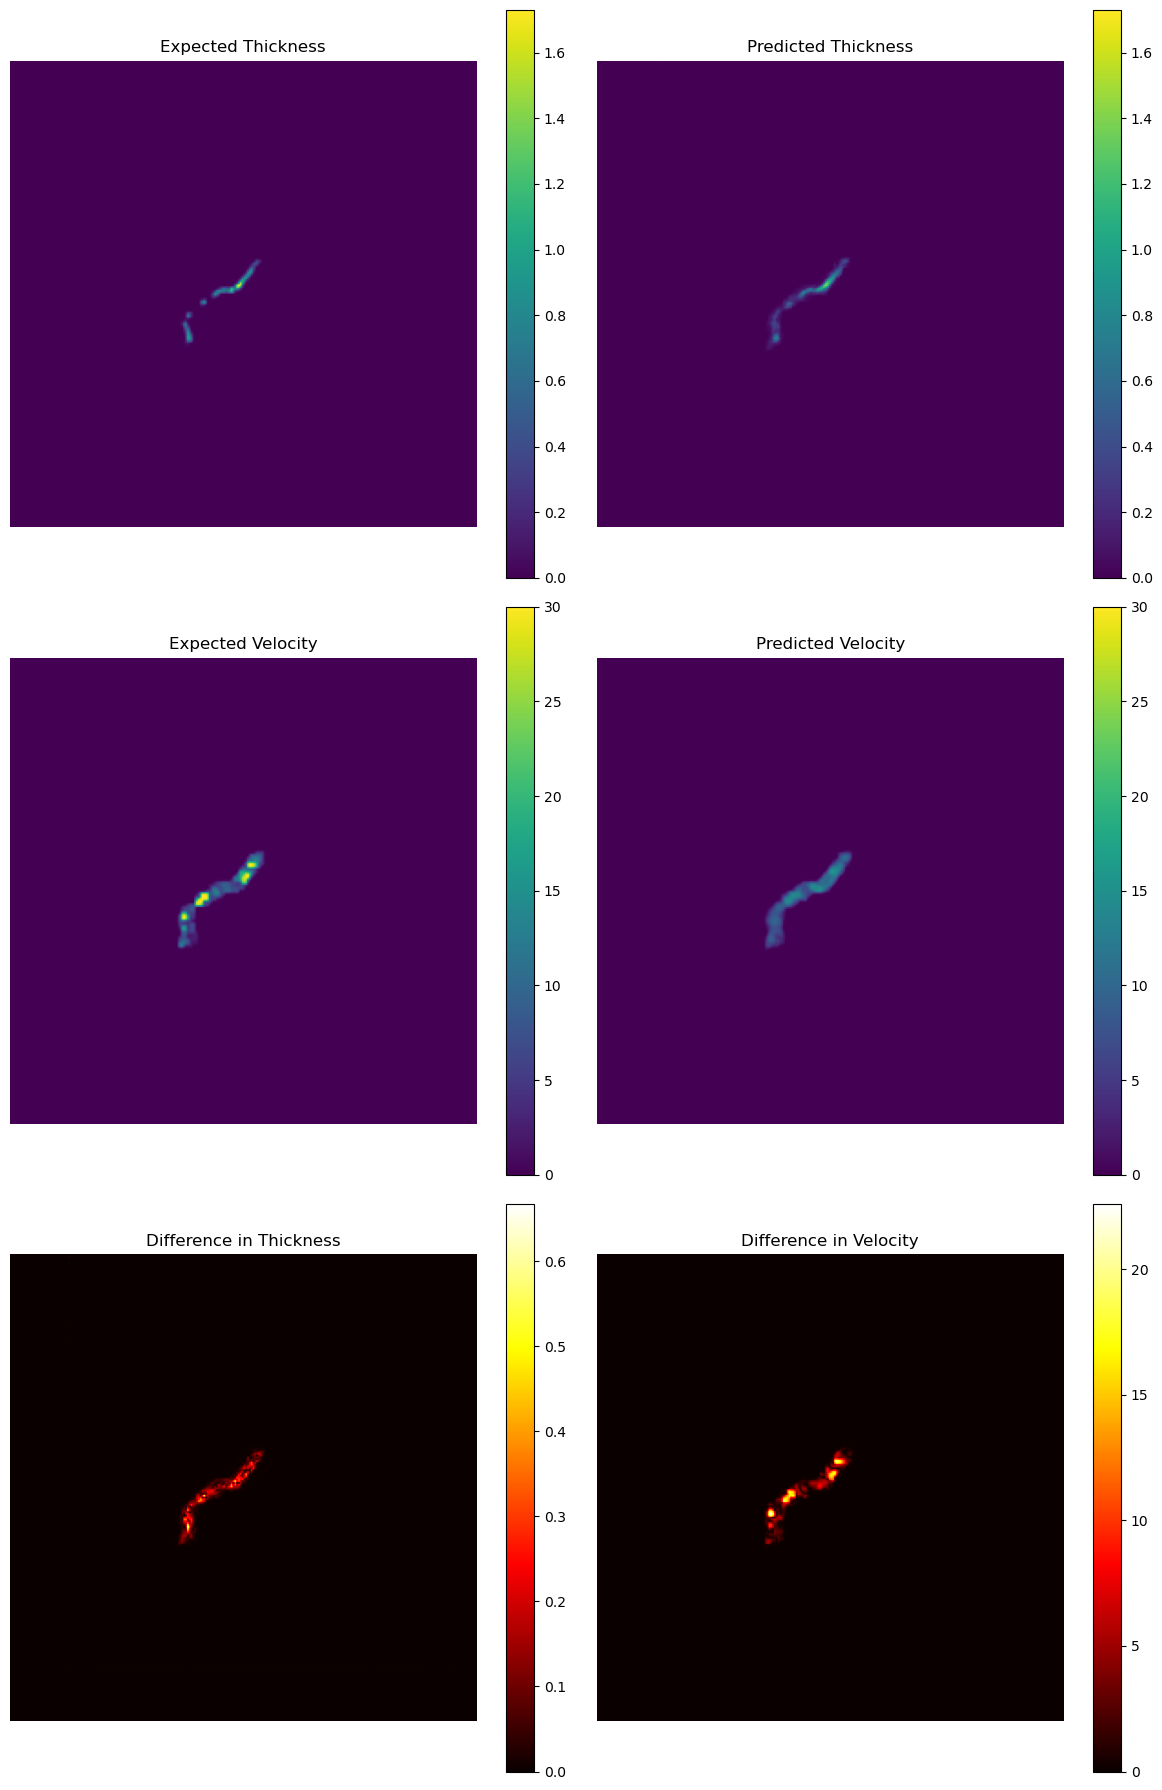

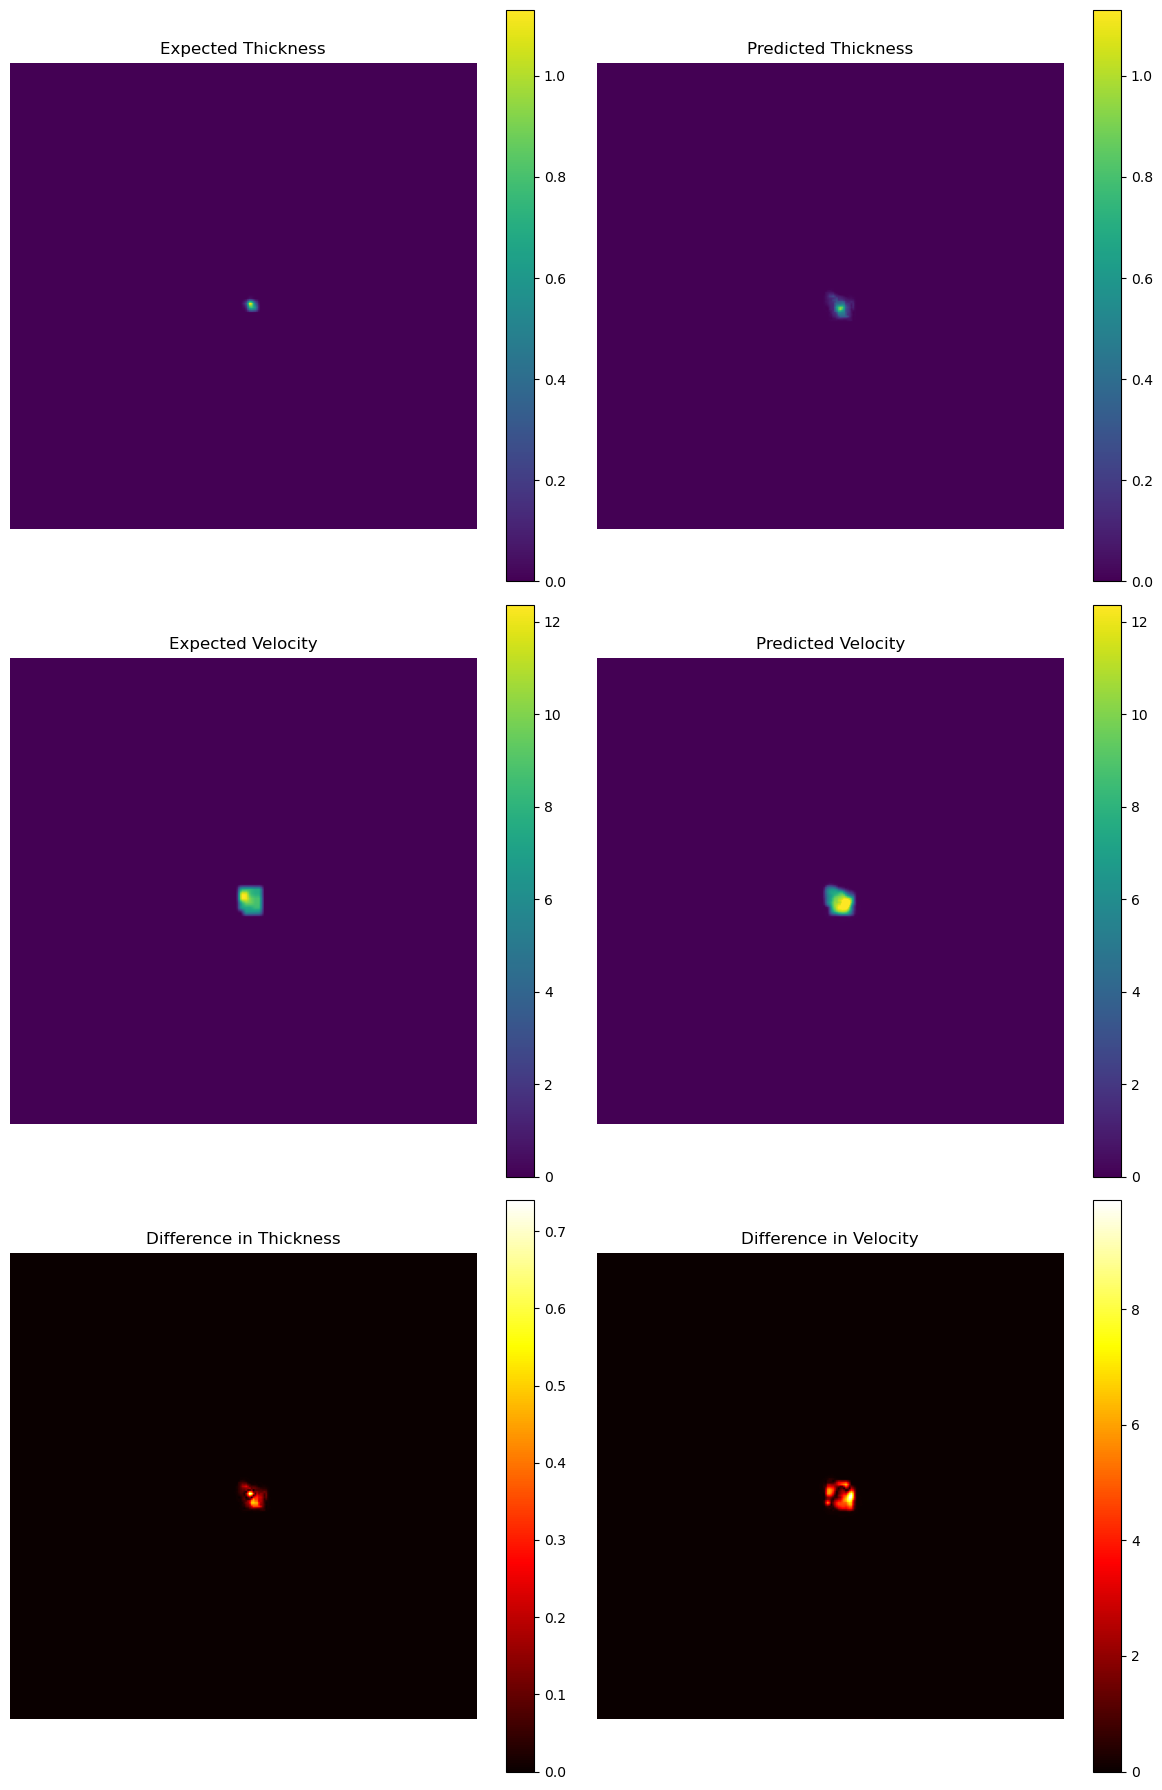

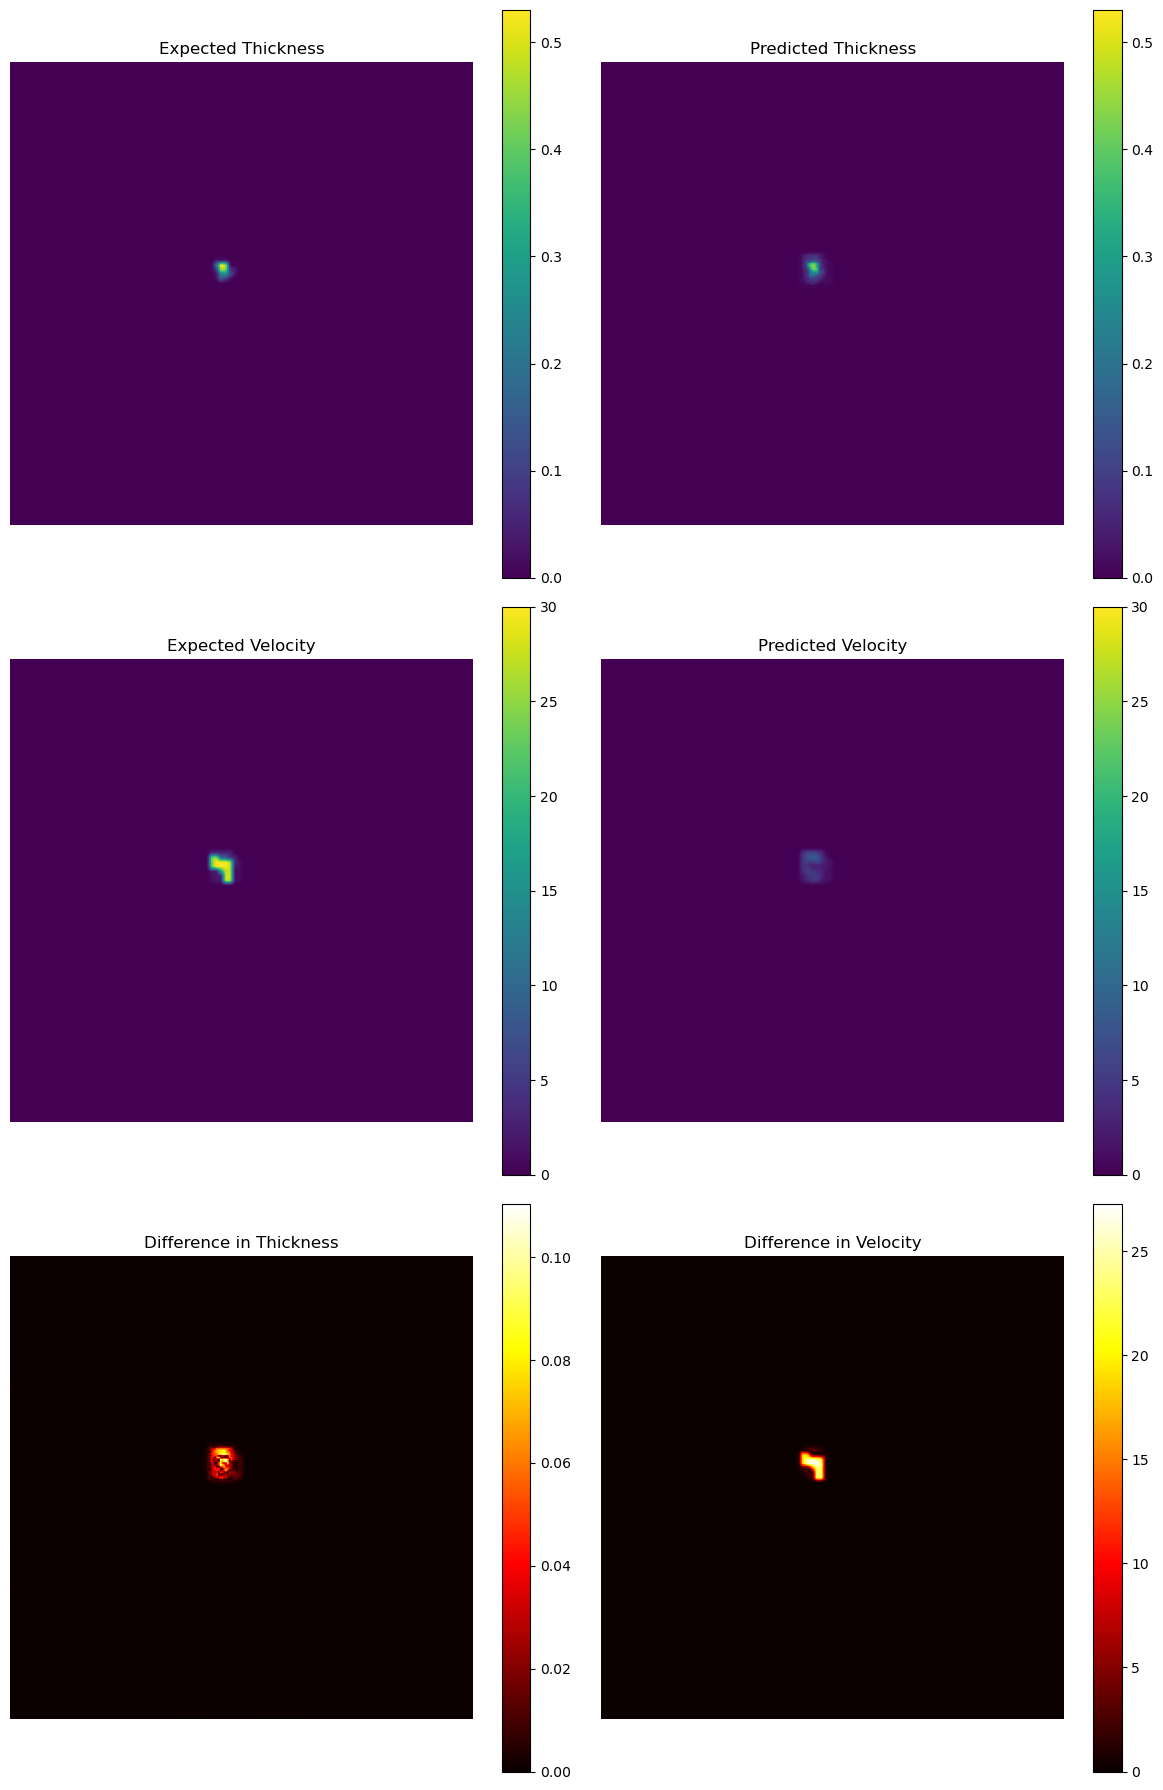

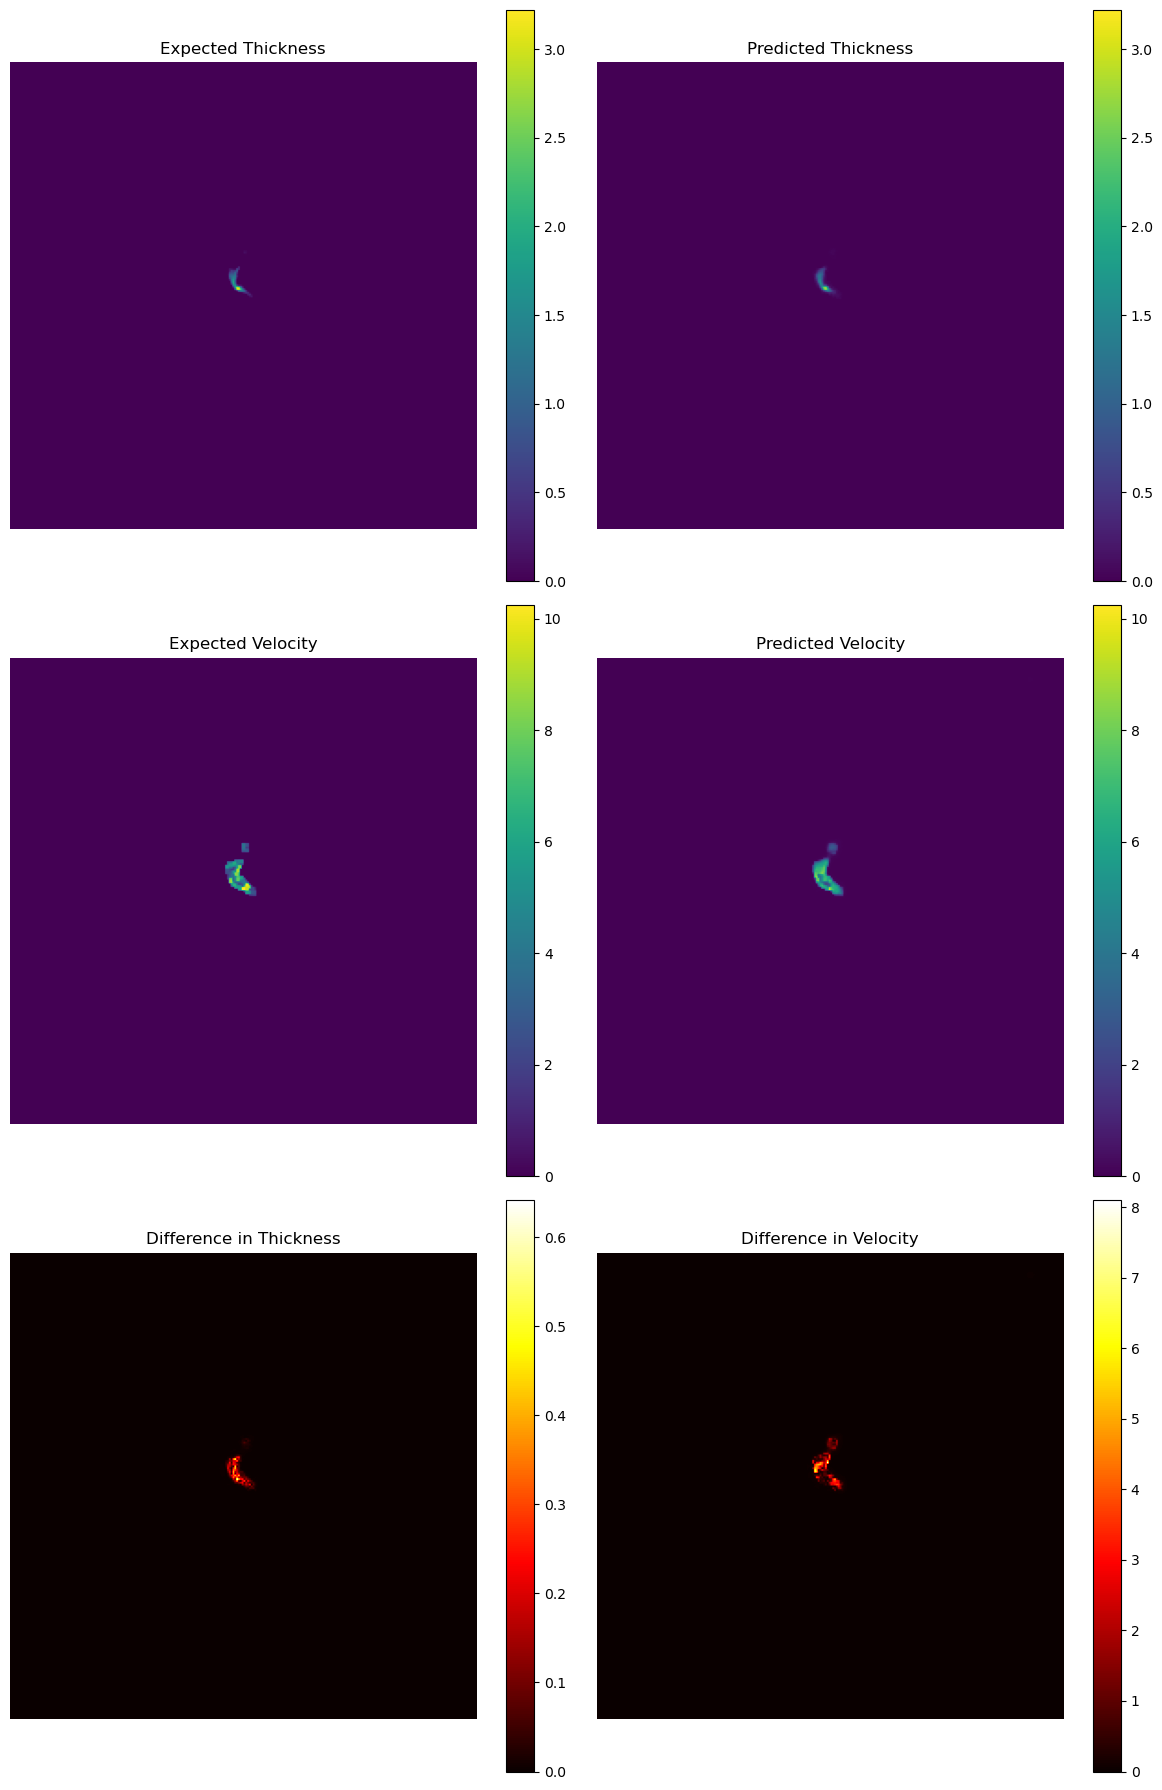

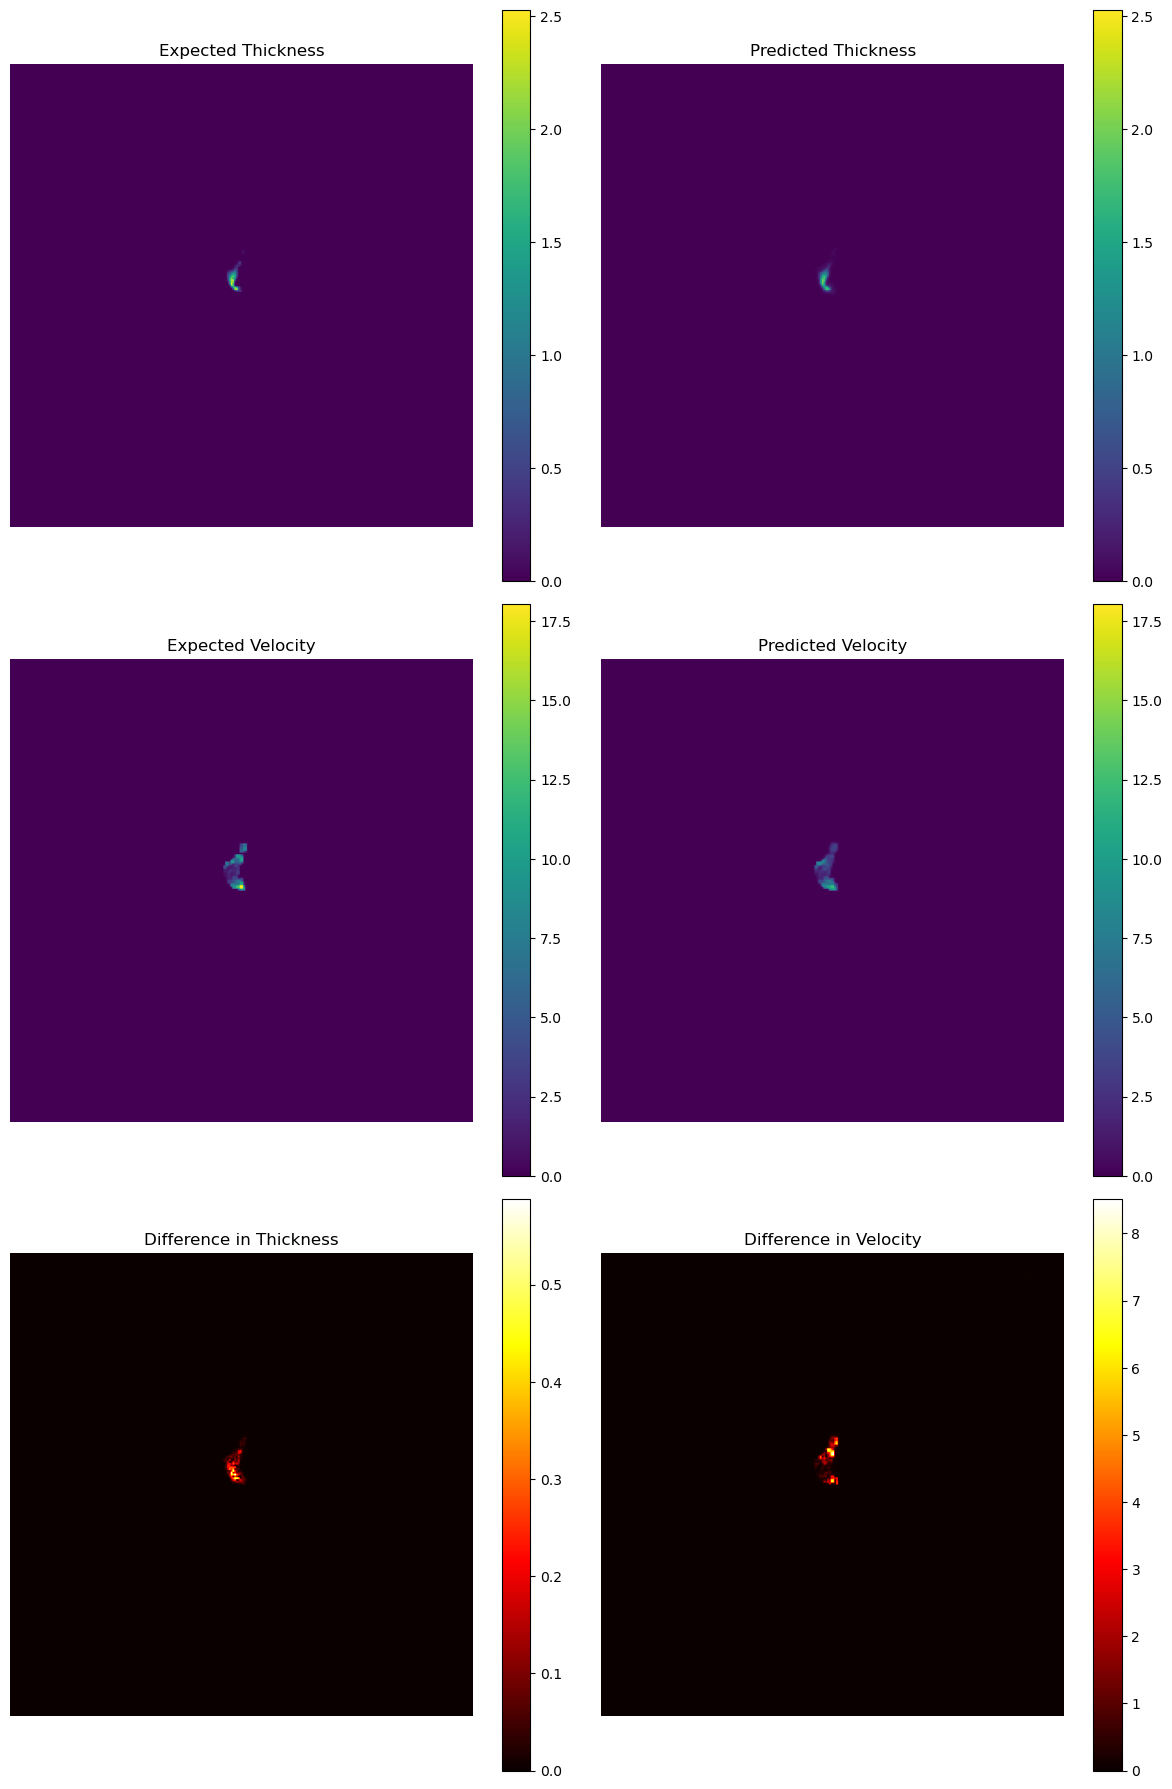

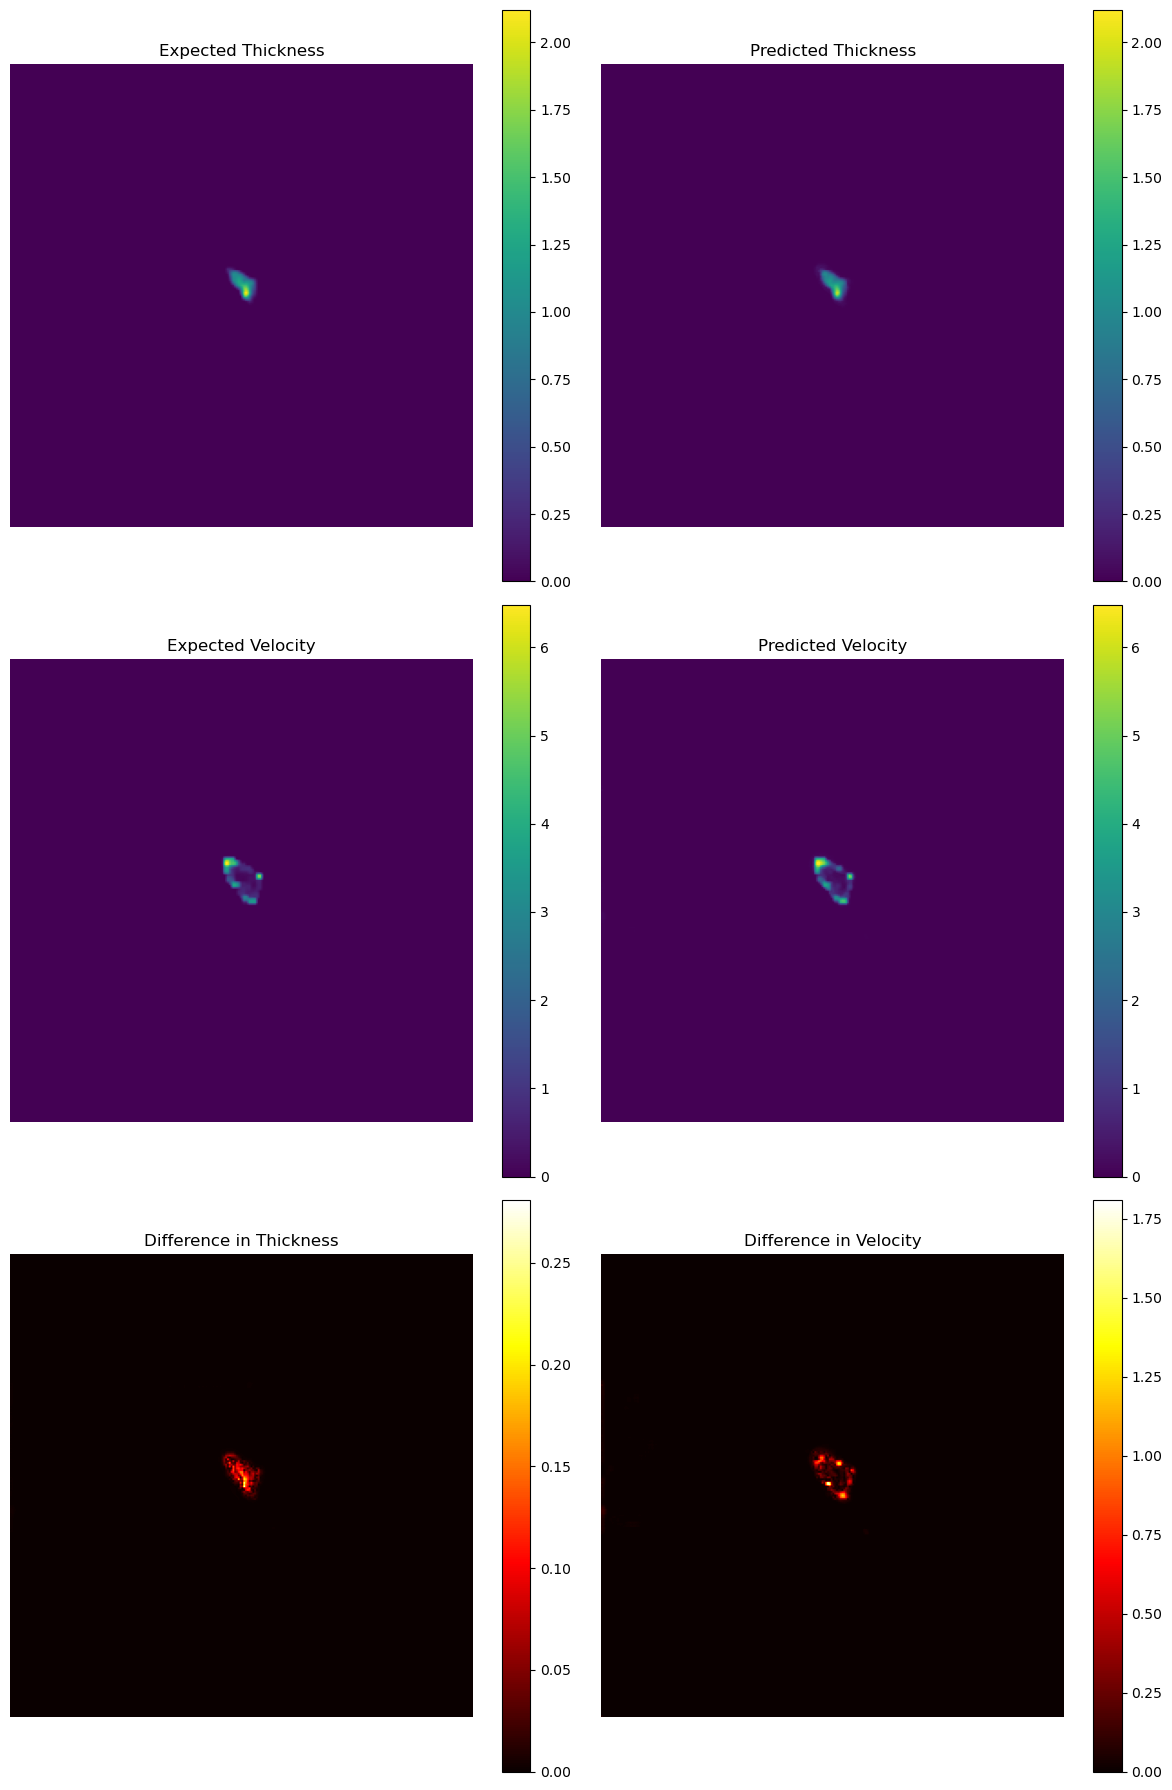

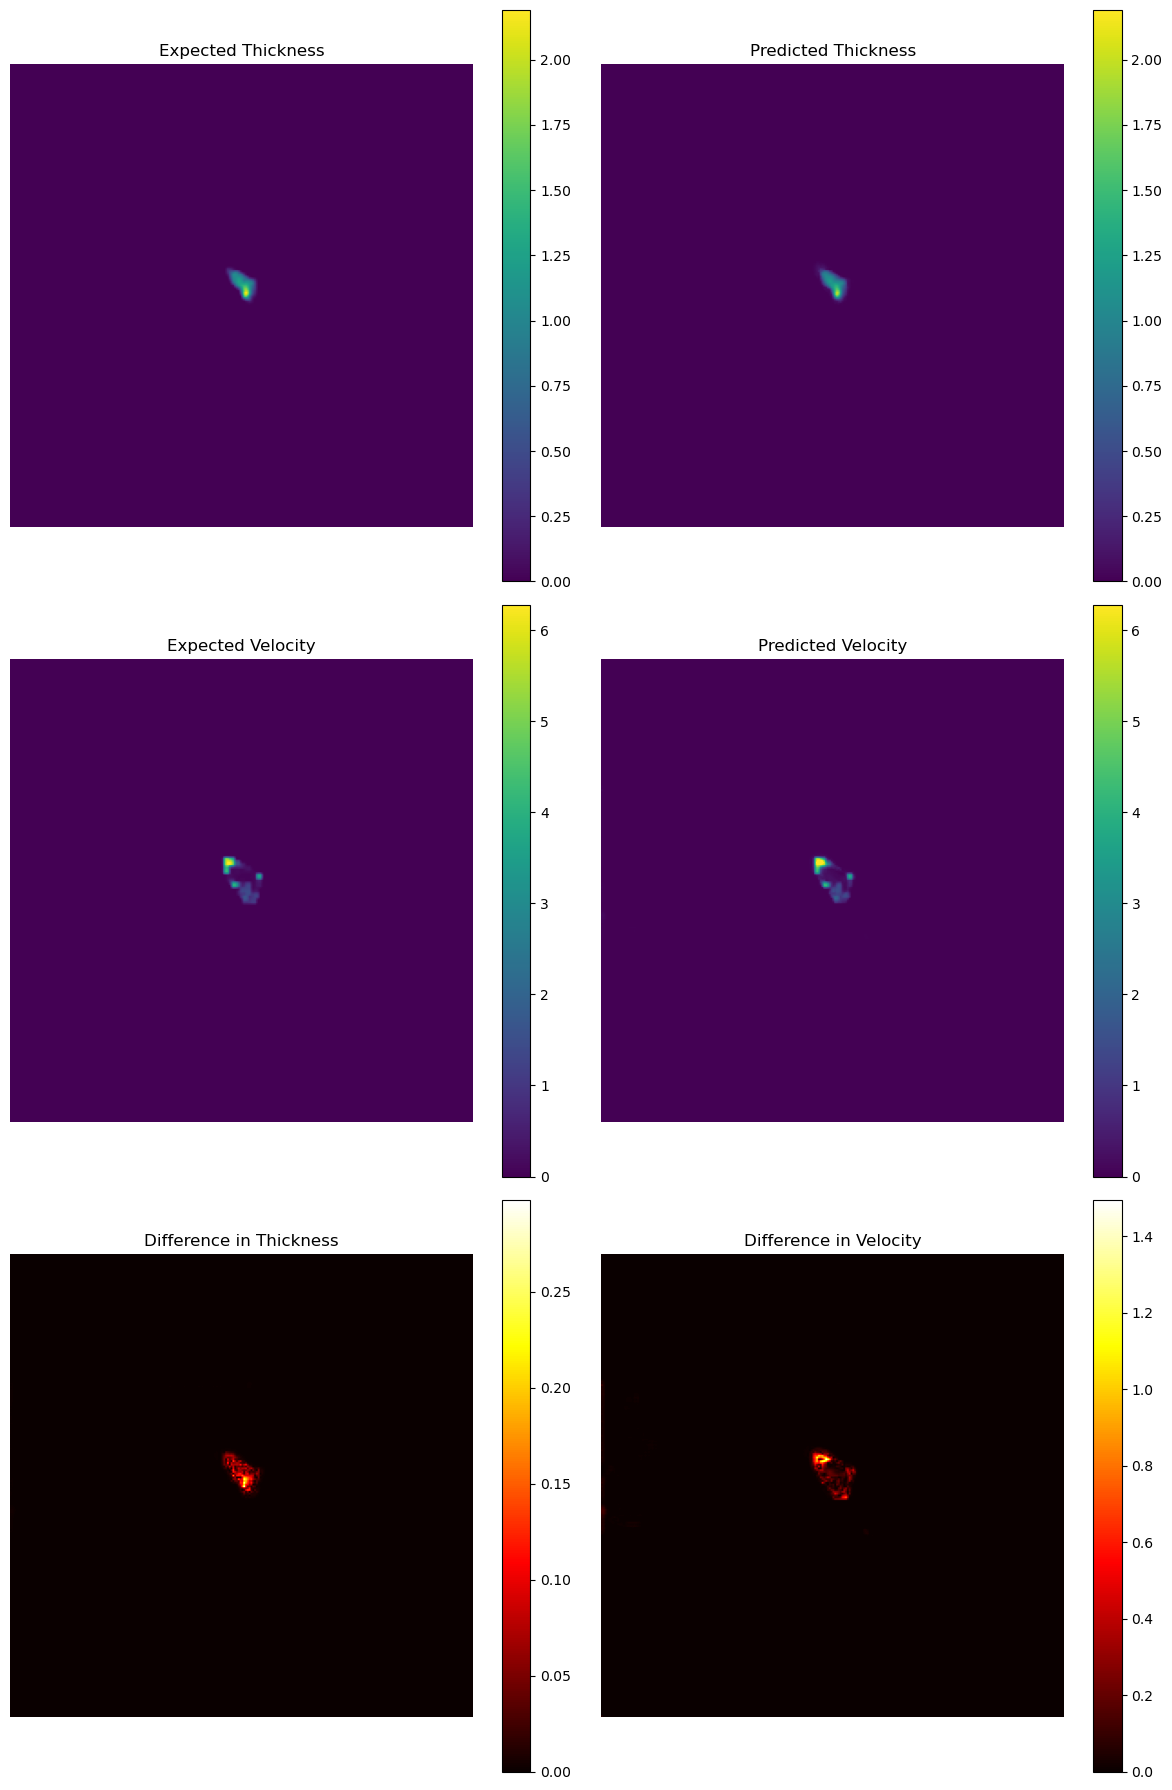

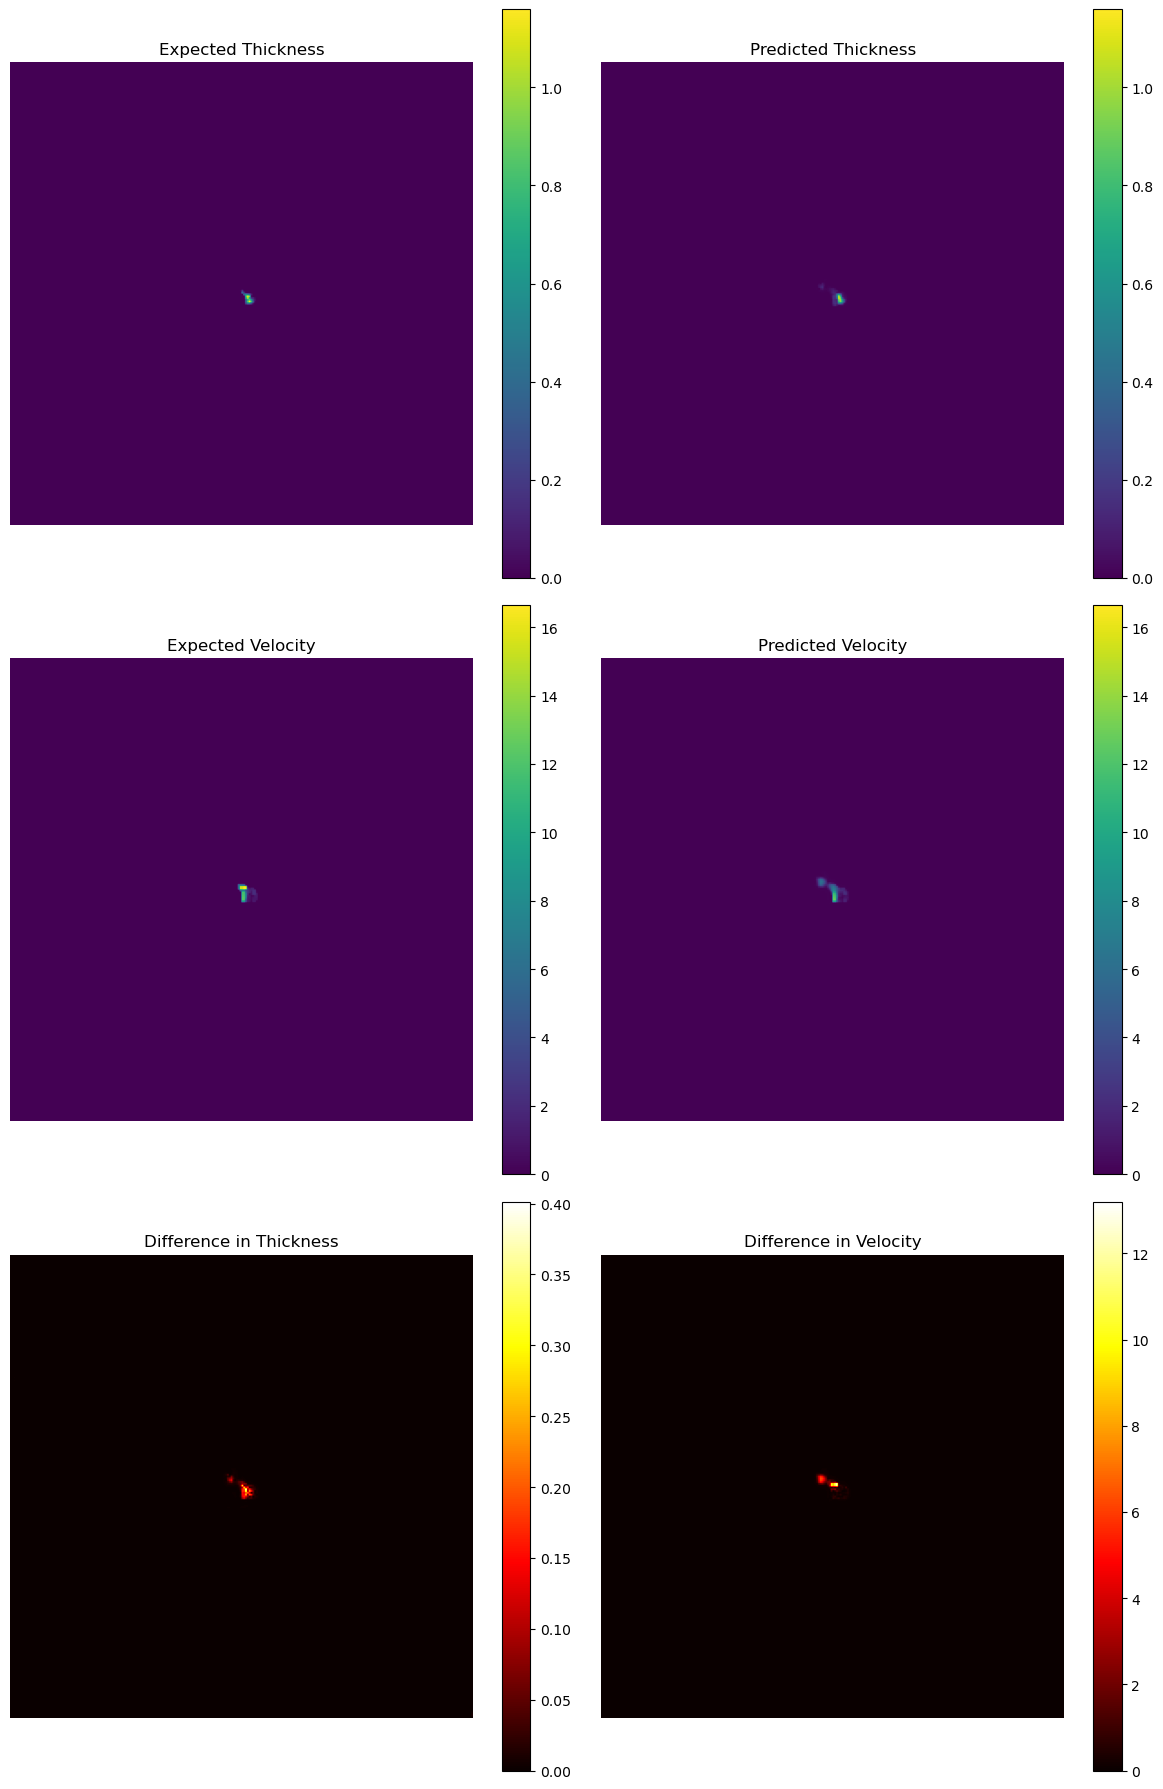

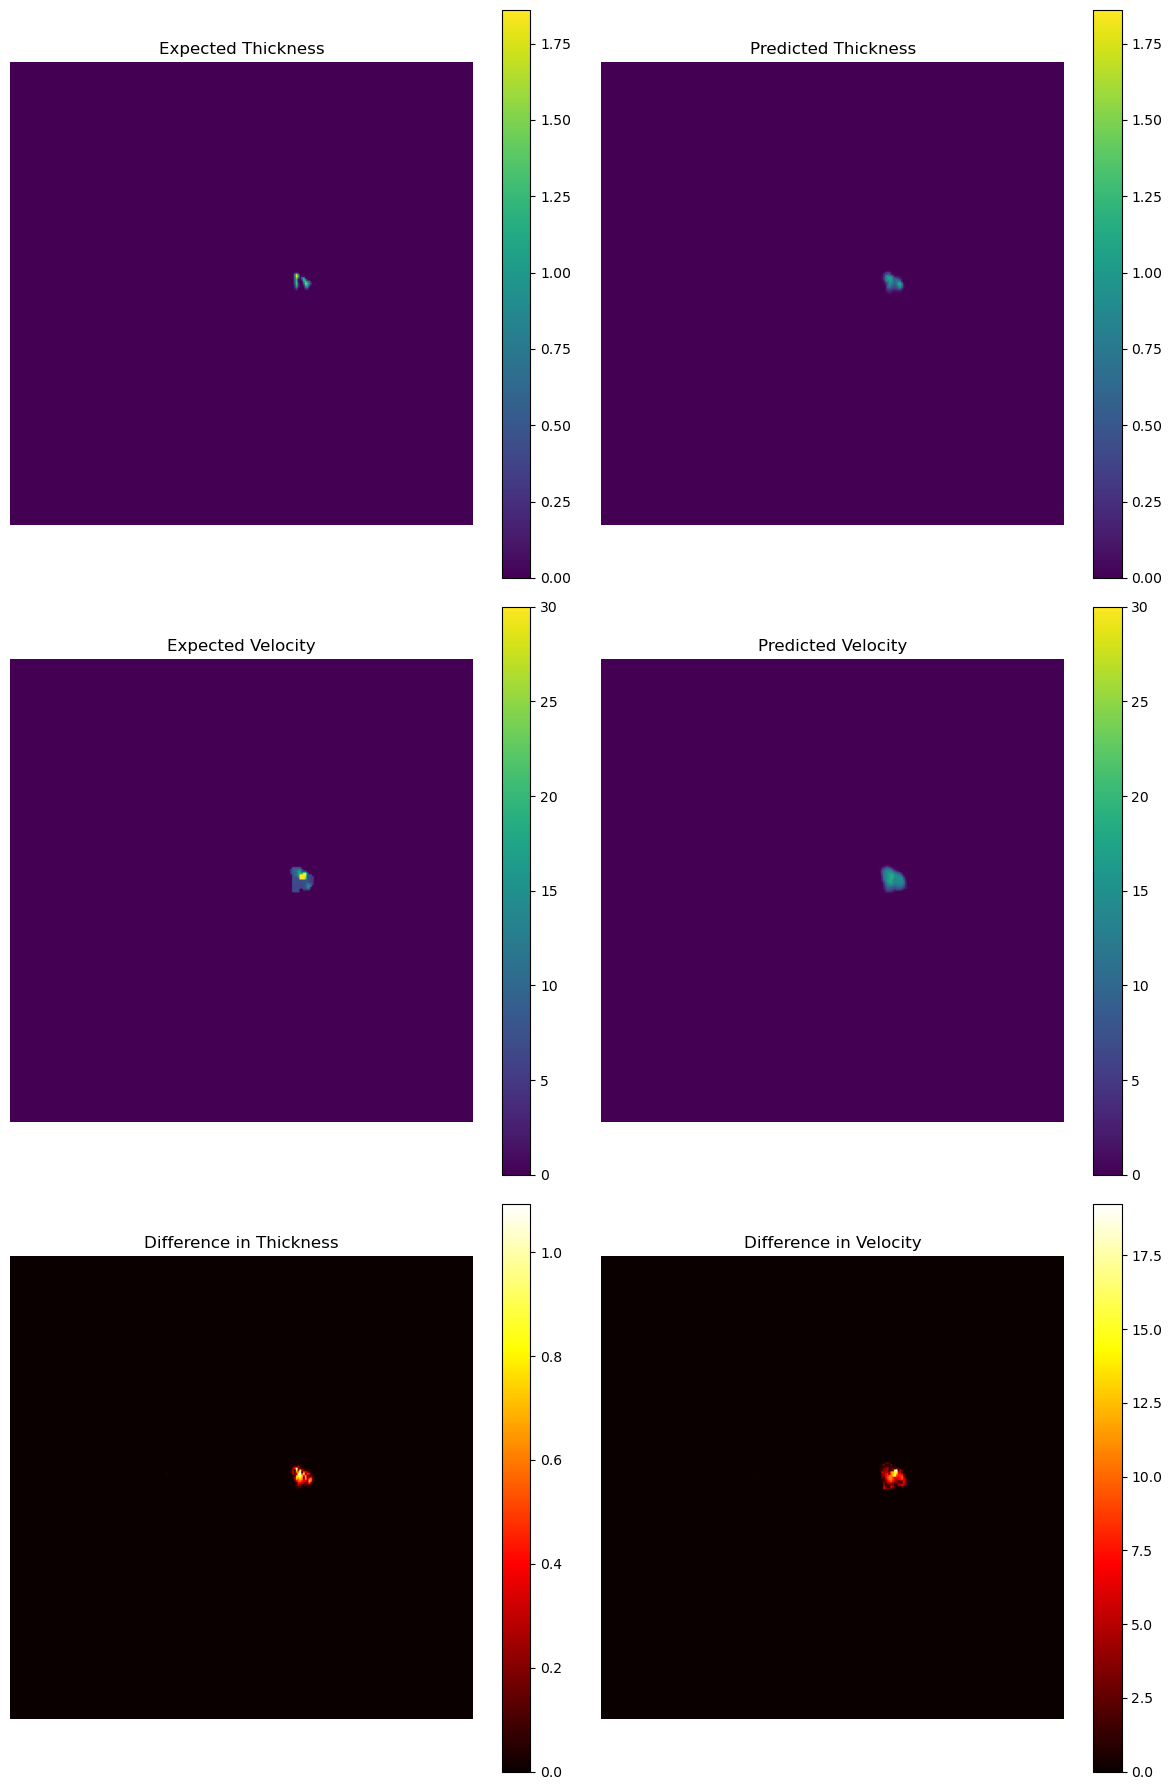

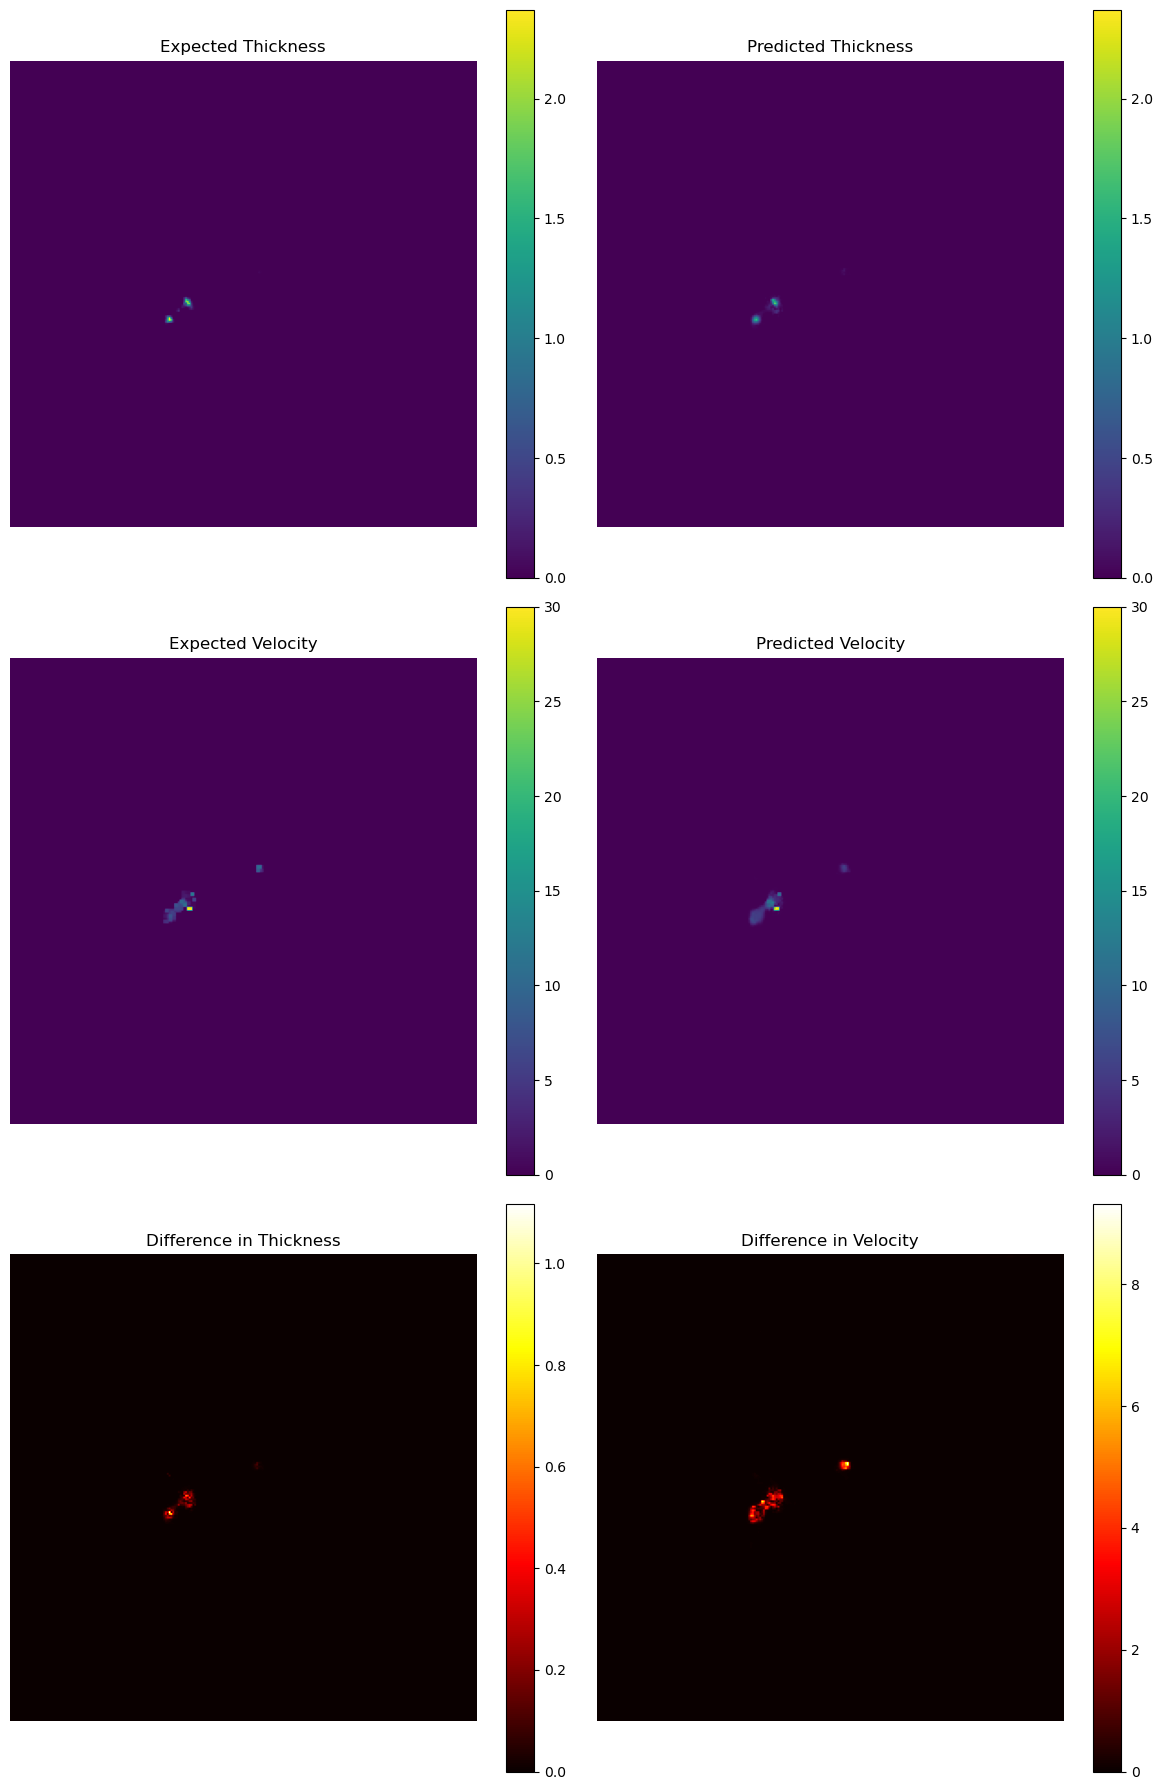

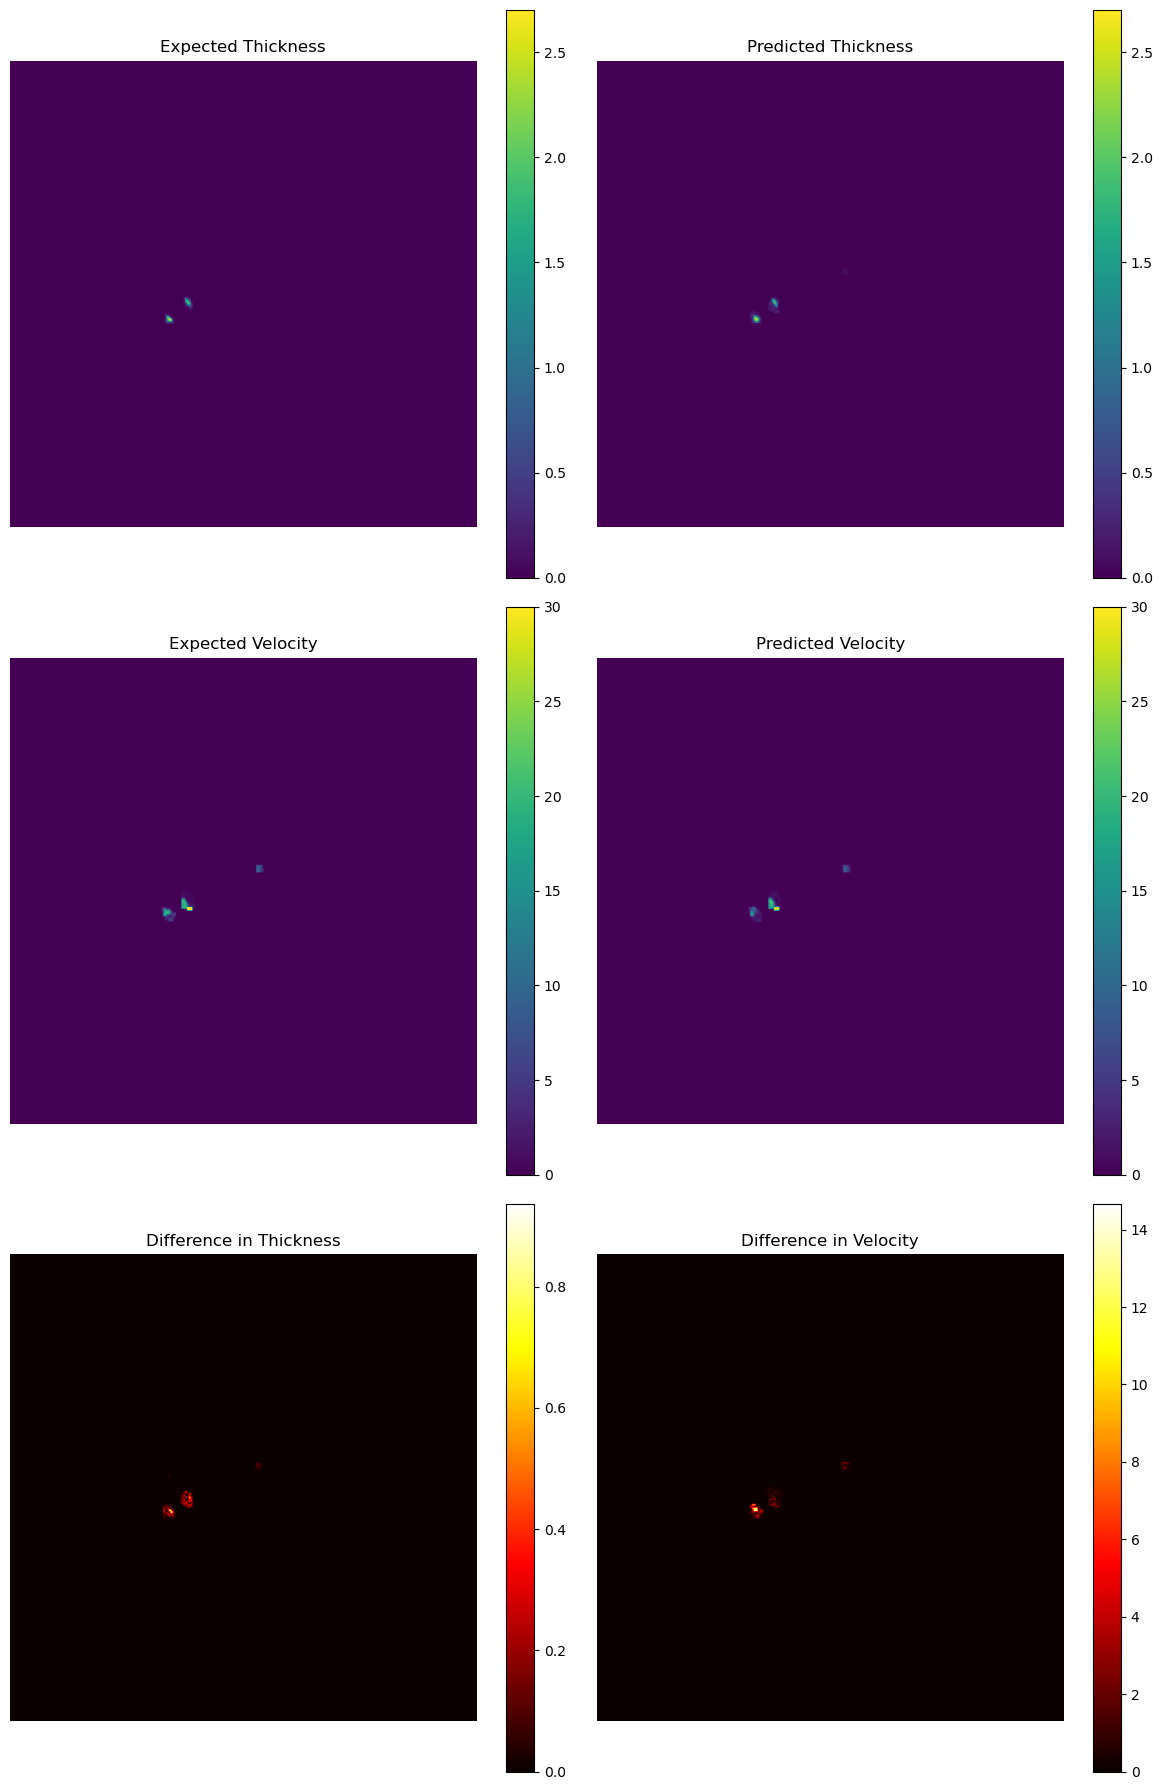

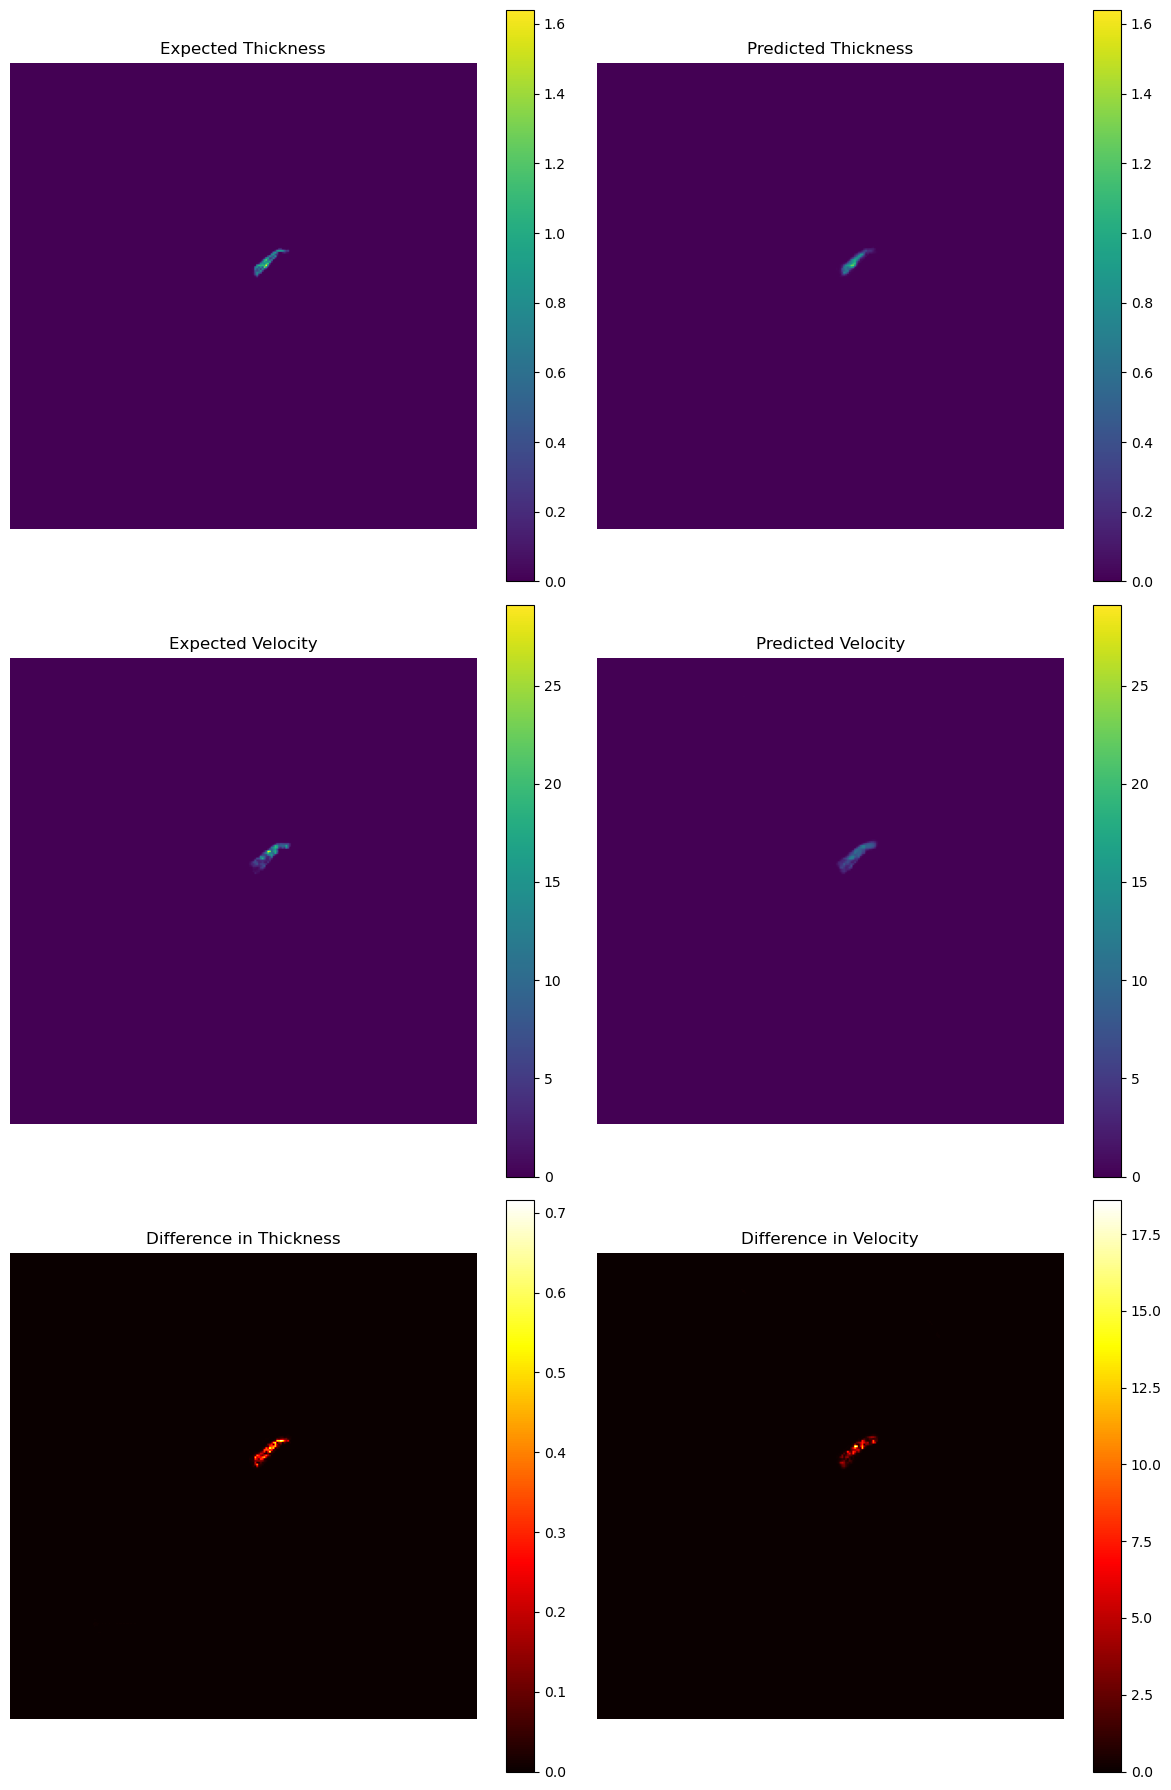

In [12]:
# Plot the expected vs predicted results
print("Plotting the expected vs predicted results...")
trainer.plot_results(test_loader, num_samples=15)